# Deep Learning Demand Forecasting
*Made by Carmen Pelayo Fernández in March, 2024*

This project addresses the critical need for effective demand forecasting in local businesses, utilizing deep learning methods. By analyzing over two decades of data from a Connecticut café, we aim to explore and identify deep learning algorithms that provide highly accurate demand projections, aiding in operational planning and strategic decision-making.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import meteostat
import datetime as dt
from sklearn.metrics import mean_absolute_percentage_error

## EDA & Data Preprocessing

I will begin the project with a Exploratory Data Analysis performing some simple **statistics** and **visualizations** to observe the nature of the data and gain insights about it.

In [2]:
data = pd.read_excel("VBCData.xlsx")
data

Unnamed: 0  Unnamed: 1       Date        Day  Breakfast   Lunch  Dinner  \
0            NaN         NaN 2023-12-31     Sunday          88    105       0   
1            NaN         NaN 2023-12-30   Saturday          56    149      28   
2            NaN         NaN 2023-12-29     Friday          30    154      17   
3            NaN         NaN 2023-12-28   Thursday          26    154      21   
4            NaN         NaN 2023-12-27  Wednesday          43    138      13   
...          ...         ...        ...        ...         ...    ...     ...   
9074         NaN         NaN 2000-01-05  Wednesday           8    110      20   
9075         NaN         NaN 2000-01-04    Tuesday           5     92       0   
9076         NaN         NaN 2000-01-03     Monday           3     79       0   
9077         NaN         NaN 2000-01-02     Sunday          55    161      29   
9078         NaN         NaN 2000-01-01   Saturday           2     91       0   

      Total     Weather                 Notes  Unnamed: 10  Avg Spend  
0       193    Overcast                   NaN      3649.27  18.908135  
1       233     PM Rain                   NaN      4643.05  19.927253  
2       201     PM Rain                   NaN      3715.30  18.484080  
3       201     PM Rain                   NaN      3677.01  18.293582  
4       194     PM Rain                   NaN      3239.03  16.696031  
...     ...         ...                   ...          ...        ...  
9074    138         NaN                   NaN      1320.27   9.567174  
9075     97         NaN                   NaN      1077.91  11.112474  
9076     82  Part Sunny                  Warm       840.04  10.244390  
9077    245         NaN                   NaN      2259.14   9.220980  
9078     93       Sunny  Open 11-5 Slow Start      1064.21  11.443118  

[9079 rows x 12 columns]

The following actions were taken to preprocess the data before we begin the analysis:
* Dropped unnecessary columns.
* Named column 'Revenue'.
* Checked data types.

In [3]:
data = data.drop(columns=["Unnamed: 0", "Unnamed: 1"]).rename(columns={"Unnamed: 10": "Revenue"})
data.dtypes

Date          datetime64[ns]
Day                   object
Breakfast              int64
Lunch                  int64
Dinner                 int64
Total                  int64
Weather               object
Notes                 object
Revenue              float64
Avg Spend            float64
dtype: object

All columns seem to have the proper data type. Therefore, no formatting is required here. The preprocessed dataset to be used will be the following:

### Data Summary

In [4]:
data.describe()

Date   Breakfast         Lunch       Dinner  \
count                           9079  9079.000000  9079.000000  9079.000000   
mean   2012-05-15 19:43:12.840621312    31.088115   133.909131    37.508316   
min              2000-01-01 00:00:00     0.000000     0.000000     0.000000   
25%              2006-03-19 12:00:00     8.000000    87.000000     0.000000   
50%              2012-06-05 00:00:00    15.000000   119.000000    32.000000   
75%              2018-08-22 12:00:00    40.000000   162.000000    59.000000   
max              2023-12-31 00:00:00   222.000000   585.000000   209.000000   
std                              NaN    36.934156    72.448446    37.483778   

             Total       Revenue    Avg Spend  
count  9079.000000   9070.000000  8915.000000  
mean    202.517678   2985.114173    14.730858  
min       0.000000      0.000000     0.000000  
25%     114.000000   1561.997500    12.609058  
50%     172.000000   2508.100000    14.318143  
75%     260.500000   3929.772500    16.126611  
max     821.000000  14833.490000   568.090000  
std     123.561512   1961.484184     6.894470

From this summary table we can observe there are **missing values.** The dataset contains records from 9,079 days (i.e. 9078/366 = 24.8 years). Interestingly, we only have 'Avg Spend' (average expenditure) data from 8915 days. That means 164 values are missing and should be handled appropriately. Similarly, we only have 'Revenue' data from 9070 days, meaning 9 values are missing. Missing values should either be dropped or filled in with interpolated data to prevent the impact of null values on predictions. Given the time series nature of the problem, dropping values would discontinue the series and this could cause problems. Therefore, we will fill in the missing values. There are multiple methods to do so, including the *mean imputation*, *median imputation*, *Last Observation Carried Forward (LOCF)*, *Next Observation Carried Backward (NOCB)*, *linear interpolation* or the *spline imputation* ([GeeksForGeeks](https://www.geeksforgeeks.org/how-to-deal-with-missing-values-in-a-timeseries-in-python/), accessed March 2024). Given that there are only a small number of missing values, we can perform **spline interpolation** on them, which is the most comùtationally expensive method but also the most accurate for capturing complex trends and subtle changes in time series data. It estimates missing values by fitting a flexible, curved line through the data points.

In [5]:
data["Total"] = data["Total"].replace(0, np.nan).interpolate(option='spline')

By doing this, I am **dealing with the days where the restaurant was closed** (i.e., the count of meals served was 0), so that it does not impact predictions.

### Demand Evolution

The **total demand per quarter** will now be plotted to observe how revenue has evolved over the years.

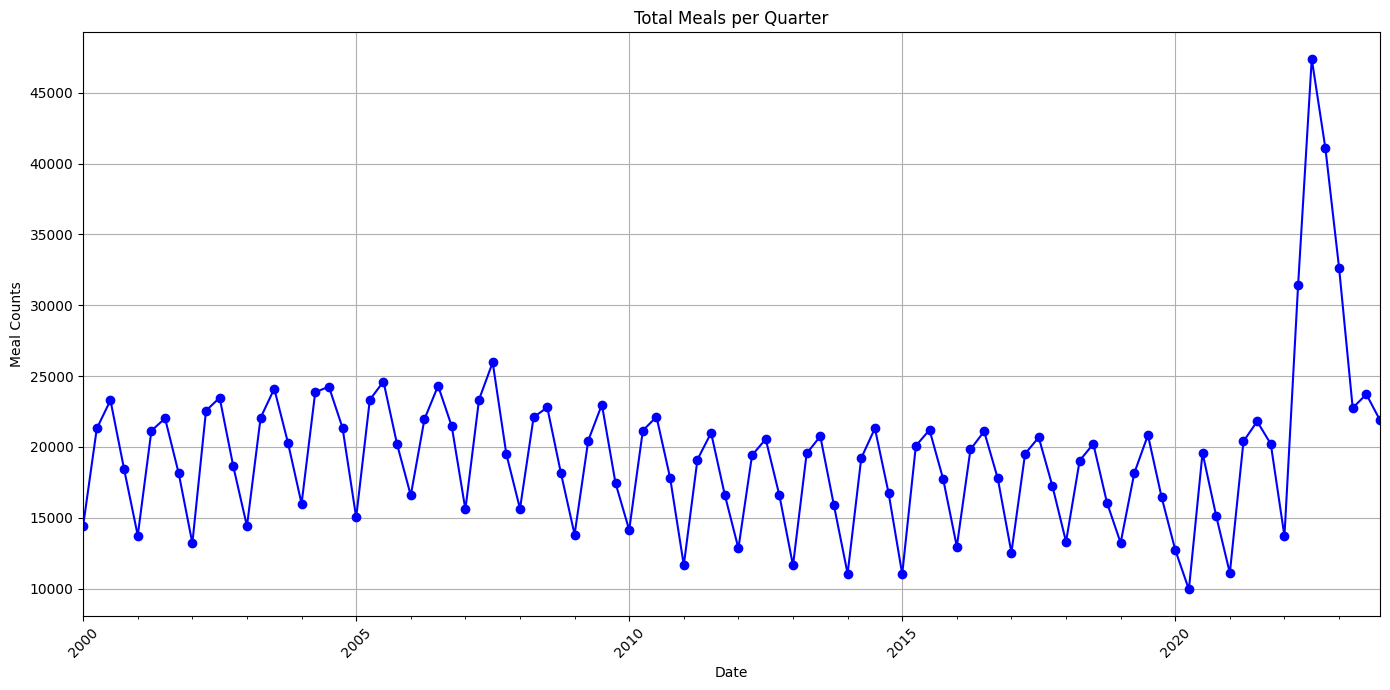

In [6]:
# Data Resampling (to obtain quarterly observations)
data.set_index('Date', inplace=True)
quarterly_data = data['Total'].resample('Q').sum()

# Plotting
plt.figure(figsize=(14, 7))
quarterly_data.plot(marker='o', linestyle='-', color='b')
plt.title('Total Meals per Quarter')
plt.xlabel('Date')
plt.ylabel('Meal Counts')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

The data seems to have a clear **seasonality**, with a constant trend over the years and low variance (at least until 2021). This pattern is very convenient for time series modeling, enabling accurate predictions due to the apparent lack of random shocks that could reduce the predictability of models. Throughout the entire series, we can see that the **first quarter** of the year (i.e. the months of January, February, March) produces the **lowest earnings** in the year, with the second (April, May, June) and third (July, August, September) quarters (the **warmer months**) being the **most profitable** ones. 

### Outliers and Data Duplicates

However, this smooth seasonality is broken with the presence of a clear **outlier during 2022**. This year, revenue almost reached 3 times the value of other years' revenue. This could be due to either the effect of external factors or issues in the data collection process. During part II of this project (*Long-Term Trend Forecasting*) we will focus on the investigation of economic and sociodemographic events that may have altered the usual course of the data. However, it is interesting to note that the effect of COVID-19 (as a reference for a major sociodemographic event that impacted most businesses in the world), does not show an extreme decay in revenue. This may be indicative of 2022's outlier being potentially due to issues in the data collection process. To check for this, we will first check for **duplicated records** in the data:

In [7]:
duplicate_dates = data[data.index.duplicated()]
duplicate_dates

Day  Breakfast   Lunch  Dinner  Total    Weather Notes  \
Date                                                                       
2023-04-25    Tuesday          21     84       0  105.0  Cold As F   NaN   
2023-03-31     Friday          25    112      59  196.0        NaN   NaN   
2023-03-30   Thursday          36     99      25  160.0        NaN   NaN   
2023-03-29  Wednesday           8    107      25  140.0        NaN   NaN   
2023-03-28    Tuesday          12     87       0   99.0        NaN   NaN   
...               ...         ...    ...     ...    ...        ...   ...   
2022-05-27     Friday          21    133      95  249.0        NaN   NaN   
2022-05-26   Thursday          24    154      40  218.0        NaN   NaN   
2022-05-25  Wednesday          17    140      52  209.0  Beautiful   NaN   
2022-05-24    Tuesday          13    100       0  113.0        NaN   NaN   
2022-05-23     Monday          22    120       0  142.0        NaN   NaN   

            Revenue  Avg Spend  
Date                            
2023-04-25  2127.22  20.259238  
2023-03-31  3760.30  19.185204  
2023-03-30  3238.70  20.241875  
2023-03-29  2470.46  17.646143  
2023-03-28  1858.06  18.768283  
...             ...        ...  
2022-05-27  4586.17  18.418353  
2022-05-26  4139.37  18.987936  
2022-05-25  3877.41  18.552201  
2022-05-24  1958.33  17.330354  
2022-05-23  2353.95  16.577113  

[314 rows x 9 columns]

As suspected, there are **314 duplicated values** in the dataset. We will then proceed to remove them and replot the to quarterly revenues:

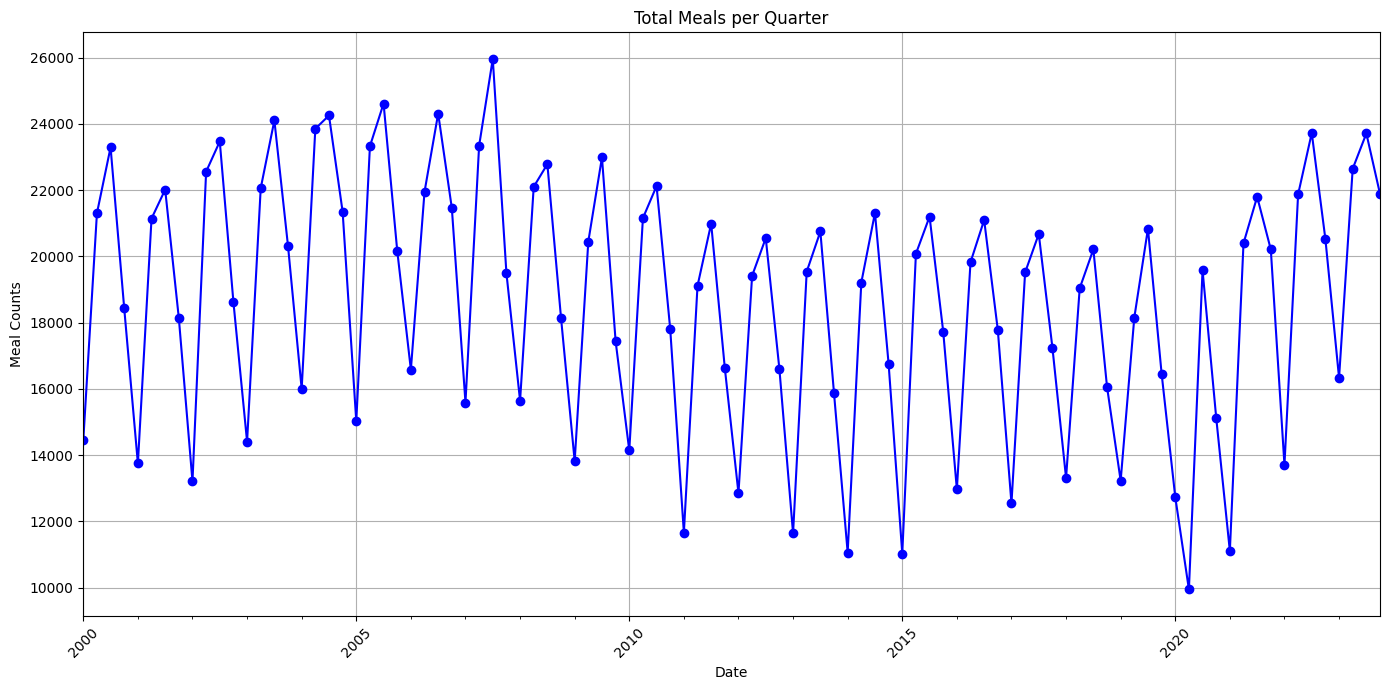

In [8]:
data = (data.reset_index().drop_duplicates(subset='Date', keep='last').set_index('Date').sort_index())
quarterly_revenue = data['Total'].resample('Q').sum()

plt.figure(figsize=(14, 7))
quarterly_revenue.plot(marker='o', linestyle='-', color='b')
plt.title('Total Meals per Quarter')
plt.xlabel('Date')
plt.ylabel('Meal Counts')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

This seems much more reasonable. Still, there is some interesting **increase after the COVID-19 pandemic** that we will explore later. With a clean dataset now, we can go on to plot more visualizations.

### Meals Evolution

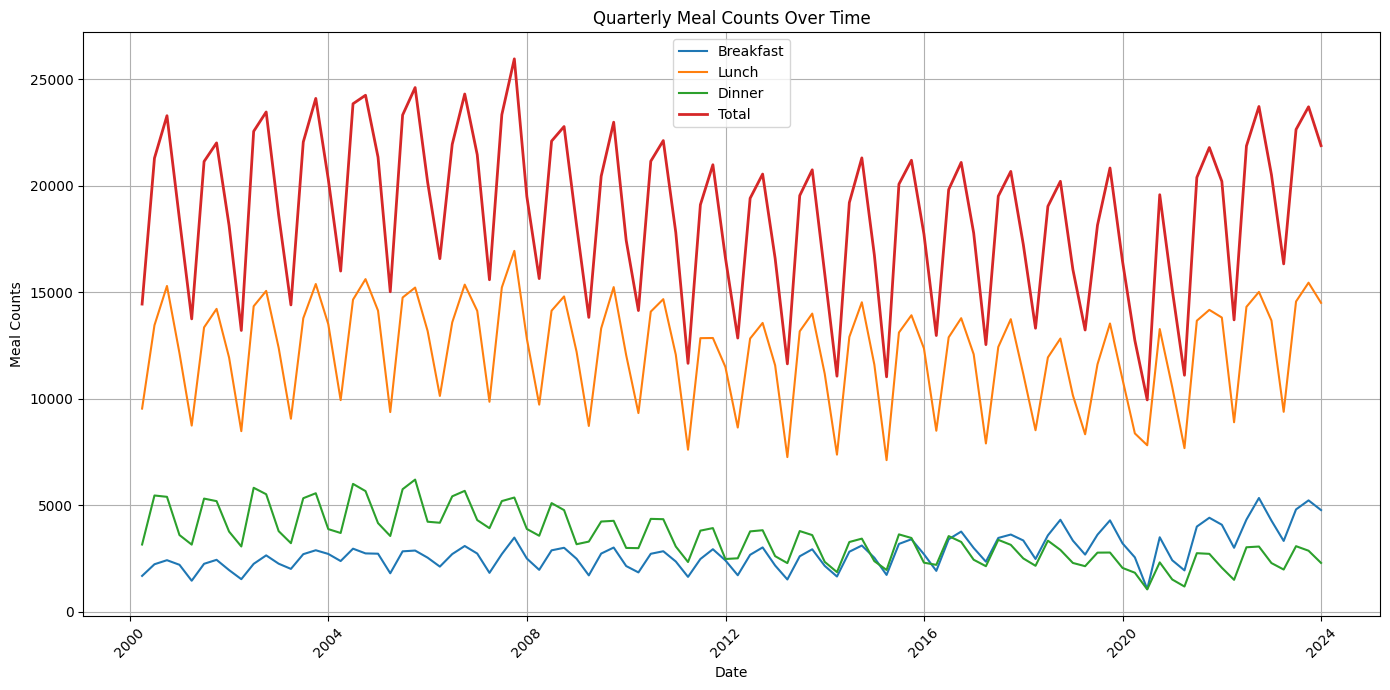

In [9]:
# Data Resampling (to obtain quarterly observations)
quarterly_meals = data[['Breakfast ', 'Lunch', 'Dinner', 'Total']].resample('Q').sum()

plt.figure(figsize=(14, 7))

# Plot each column as a line on the same graph
plt.plot(quarterly_meals.index, quarterly_meals['Breakfast '], label='Breakfast')
plt.plot(quarterly_meals.index, quarterly_meals['Lunch'], label='Lunch')
plt.plot(quarterly_meals.index, quarterly_meals['Dinner'], label='Dinner')
plt.plot(quarterly_meals.index, quarterly_meals['Total'], label='Total', linewidth=2)  # Highlighting the 'Total' line

plt.title('Quarterly Meal Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Meal Counts')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

This graph displays the counts of meals served over time, broken down by meal type: breakfast, lunch, dinner, and the total count of meals. It confirms the seasonality observed earlier, as the general levels of meal counts seem relatively consistent over the years despite some fluctuations. This suggests a **steady business performance** without significant long-term changes in customer behavior. The plot also shows **lunch being the most popular choice for customers**, followed by dinner. However, **around 2014, breakfast became more popular**, eventually and permanently surpassing dinners in the years after.

This correlation heatmap confirms our previous observations, with **lunch having the highest correlation with revenue** (0.87), implying it is probably the main source of revenue for the business. On the other hand, Average spending (Avg Spend) shows very little to no correlation with meal counts or revenue, suggesting that the **average spending per customer is independent of the volume of meals sold**. This is useful to discard the hypothesis that busier days in the restaurant (for instance, due to a special sports event) or celebration reservations (i.e. people booking space for their guests) do not imply people will spend more.

### Categorical data encoding 

Now that all data is clean, I will proceed to **encode the categorical variables**. This is required so that the forecasting algorithms can then digest these features to predict numerical values. Usually, this is done using ordinal or one-hot encoding.

### Feature 1: *Day of the week*

In [10]:
data["Day"].unique()

array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday'], dtype=object)

Two different encoding methods could be used here:

*  **Ordinal Encoding**: This method assigns a unique integer to each category. The days of the week could be mapped to integers (e.g., Monday=1, Tuesday=2, ..., Sunday=7). The potential issue with ordinal encoding is that it introduces artificial ordering and magnitude differences that may not be present or relevant. For example, the model may interpret the difference between Sunday (7) and Monday (1) as significant when they are adjacent days.
*  **One-Hot Encoding**: Each category is represented by a binary vector with all zeros except for a one at the category's index. This method does not impose any ordinality and treats each day as an independent feature. However, it increases the dimensionality of the feature space.

I will therefore choose **one-hot encoding**, despite the required dimensionality increase, such that no order or distance is assumed between days.

### Feature 2: *Weather*

In [11]:
print(data["Weather"].unique())
print(f'There are {len(data["Weather"].unique())} different values of weather.')

['Sunny' nan 'Part Sunny' 'cold' 'beautiful' 'Rain' 'Snow' 'Cold'
 'Lite Snow' 'Overcast' 'Beautiful' 'sunny/rain' 'sunny/thun' 'cloudy'
 'Hot/Humid' 'Cloudy' 'Holiday' 'H & H' 'Mixed' 'Drizzle' 'Fog' 'Snow PM'
 'Rain AM' 'closed 1p' 'snow' 'Humid' 'Chilly' 'Windy' 'Sun/Chill' 'Odd'
 'PM Rain' 'RAIN' 'COLD RAIN' 'rain' 'Rain Am' 'See Notes' 'Warm'
 'Cold As F' 'Hot' 'Blizzard']
There are 40 different values of weather.


We can see that some of the values in the `Weather` column have equivalent meanings (e.g. 'Sunny' and 'beautiful'), others have non-weather values (e.g. 'Holiday', 'closed 1p', etc.), etc. Therefore, prior to encoding them, I will **simplify the categories** themselves as follows:
1.  'Warm': 'Sunny', 'Part Sunny', 'beautiful', 'Beautiful', 'Sun/Chill', 'Warm'.
2.  'Hot': 'Hot/Humid', 'Humid', 'H & H', 'Hot'.
3.  'Cloudy': 'Overcast', 'cloudy', 'Cloudy', 'Fog', 'Windy', 'Chilly'.
4.  'Rain': 'Rain', 'sunny/rain', 'sunny/thun', 'Drizzle', 'Rain AM', 'PM Rain', 'RAIN', 'COLD RAIN', 'rain', 'Rain Am'.
5.  'Snow': 'Snow', 'Lite Snow', 'Snow PM', 'snow', 'Blizzard'.
6.  'Cold': 'Cold', 'Cold As F'.
7.  'Neutral': nan, 'Holiday', 'Mixed', 'closed 1p', 'Odd', 'See Notes'.

In [12]:
encoded_weather = []
for w in data["Weather"]:
    if w in ['Sunny', 'Part Sunny', 'beautiful', 'Beautiful', 'Sun/Chill', 'Warm']:
        encoded_weather.append('Warm')
    elif w in ['Hot/Humid', 'Humid', 'H & H', 'Hot']:
        encoded_weather.append('Hot')
    elif w in ['Overcast', 'cloudy', 'Cloudy', 'Fog', 'Windy', 'Chilly']:
        encoded_weather.append('Cloudy')
    elif w in ['Rain', 'sunny/rain', 'sunny/thun', 'Drizzle', 'Rain AM', 'PM Rain', 'RAIN', 'COLD RAIN', 'rain', 'Rain Am']:
        encoded_weather.append('Rain')
    elif w in ['Snow', 'Lite Snow', 'Snow PM', 'snow', 'Blizzard']:
        encoded_weather.append('Snow')
    elif w in ['Cold', 'Cold As F']:
        encoded_weather.append('Cold')
    else:
        encoded_weather.append('Neutral')
data['Weather'] = encoded_weather

In [13]:
data.head(3)

Day  Breakfast   Lunch  Dinner  Total  Weather  \
Date                                                              
2000-01-01  Saturday           2     91       0   93.0     Warm   
2000-01-02    Sunday          55    161      29  245.0  Neutral   
2000-01-03    Monday           3     79       0   82.0     Warm   

                           Notes  Revenue  Avg Spend  
Date                                                  
2000-01-01  Open 11-5 Slow Start  1064.21  11.443118  
2000-01-02                   NaN  2259.14   9.220980  
2000-01-03                  Warm   840.04  10.244390

Now, I can proceed to apply one-hot encoding to the new `Weather` column (with 7 categories now only).

In [14]:
weather = pd.get_dummies(data['Weather'], prefix='Weather').astype(int) # If we don't add .astype(int) then it returns booleans
data = pd.concat([data, weather], axis=1) # Append to clean dataset
data = data.drop('Weather', axis=1) # Drop original 'Weather' categorical column (now unnecessary)
data.head()

Day  Breakfast   Lunch  Dinner  Total                 Notes  \
Date                                                                            
2000-01-01   Saturday           2     91       0   93.0  Open 11-5 Slow Start   
2000-01-02     Sunday          55    161      29  245.0                   NaN   
2000-01-03     Monday           3     79       0   82.0                  Warm   
2000-01-04    Tuesday           5     92       0   97.0                   NaN   
2000-01-05  Wednesday           8    110      20  138.0                   NaN   

            Revenue  Avg Spend  Weather_Cloudy  Weather_Cold  Weather_Hot  \
Date                                                                        
2000-01-01  1064.21  11.443118               0             0            0   
2000-01-02  2259.14   9.220980               0             0            0   
2000-01-03   840.04  10.244390               0             0            0   
2000-01-04  1077.91  11.112474               0             0            0   
2000-01-05  1320.27   9.567174               0             0            0   

            Weather_Neutral  Weather_Rain  Weather_Snow  Weather_Warm  
Date                                                                   
2000-01-01                0             0             0             1  
2000-01-02                1             0             0             0  
2000-01-03                0             0             0             1  
2000-01-04                1             0             0             0  
2000-01-05                1             0             0             0

### Feature 3: *Notes*

In [15]:
print(data["Notes"].unique())

['Open 11-5 Slow Start' nan 'Warm' ...
 'Beautiful Day - Garnet Rogers - 55' 'Power Outage' 'Christmas Eves']


There are **1717 different notes**.

In [16]:
print('Blank notes:', data['Notes'].isna().sum())
print('Non-blank notes:', len(data) - data['Notes'].isna().sum())
print('Proportion of blank notes:', data['Notes'].isna().sum()/len(data)*100, '%')

Blank notes: 6836
Non-blank notes: 1929
Proportion of blank notes: 77.99201369081574 %


**78%** of the notes in this dataset are **blank** (do not convey any information). But, can we get any information from the others? Let's try doing some **Natural Language Processing**. 

#### VADER

I will assign each note a **sentiment score** using the pre-trained model **VADER (Valence Aware Dictionary and sEntiment Reasoner)**, which works well with social media text and informal language.  VADER uses a combination of a sentiment lexicon, which is a list of lexical features (e.g., words) labeled according to their semantic orientation as either positive or negative, along with a set of rule-based modeling for text analysis.

The sentiment score produced by VADER represents the overall emotional tone of a piece of text, as follows:
*  Positive score (> 0): The text is considered to have a positive sentiment. The closer the score is to +1, the more positive the sentiment.
*  Neutral score (= 0): The text is considered neutral, lacking any significant positive or negative sentiment.
*  Negative score (< 0): The text is considered to have a negative sentiment. The closer the score is to -1, the more negative the sentiment.

VADER, in particular, computes the sentiment score using a combination of qualitative and quantitative methods:
1. It starts with a list of lexical features (e.g., words) which are labeled according to their semantic orientation as either positive or negative.
2. Each word in the lexicon has a score that ranges from -4 to +4, with negative scores indicating negative sentiment and positive scores indicating positive sentiment.
3. VADER analyzes the text to see which words it contains and aggregates the scores of those words. It also takes into account aspects like context, word order, punctuation, and capitalization, which can amplify or reduce the sentiment intensity.

The compound score is a normalized score that takes into account the sum of all the lexicon ratings that have been normalized between -1 and 1. This is the most useful metric for a single measure of sentiment for a given text.

In [17]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Initialize the VADER sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to apply sentiment analysis to each note
def get_sentiment(note):
    if pd.isna(note) or note == '': # Check if the note is NaN or empty string, return neutral sentiment (0
        return 0
    sentiment_score = sia.polarity_scores(note)
    return sentiment_score['compound']  # Compound score represents the overall sentiment

# Apply the function to the 'Notes' column to get the sentiment score
data['Notes_Sentiment'] = data['Notes'].apply(get_sentiment)

In [18]:
data.loc[data['Notes'].notnull()][:50][['Total', 'Notes', 'Notes_Sentiment']]

Total                               Notes  Notes_Sentiment
Date                                                                  
2000-01-01   93.0                Open 11-5 Slow Start           0.0000
2000-01-03   82.0                                Warm           0.2263
2000-01-08  298.0                    Erica Wheeler 15           0.0000
2000-01-10   60.0                       $850 Catering           0.0000
2000-01-11   87.0                    $800.00 Catering           0.0000
2000-01-13   42.0                        Snow all day           0.0000
2000-01-21   97.0                 Very Cold and Windy           0.0000
2000-01-22  192.0             Louise Taylor 12 people           0.0000
2000-01-23  224.0                      Howie Bursen +           0.0000
2000-01-25   87.5                    6"-8" Sonw Yucky          -0.4215
2000-01-26   90.0                      Lingering snow           0.0000
2000-01-29  232.0          Maria Sangiolo - 25 people           0.0000
2000-02-03  126.0                       Light Snow PM           0.0000
2000-02-04  136.0                         Open Mike -           0.0000
2000-02-05  227.0   Carl Gacho & Rob Laurens 2 Poeple          -0.5574
2000-02-07   86.0                   Register Problems          -0.4019
2000-02-08   48.0                  Register Problems*           0.0000
2000-02-12  266.0                                Cold           0.0000
2000-02-18   61.0                  snow closed at two           0.0000
2000-02-19  199.0            Sally Rogers - 50 People           0.0000
2000-02-22   90.0            school vacation nice day           0.4215
2000-02-26  239.0             Dave Gerard - 30 People           0.0000
2000-03-04  360.0            Amy Galatain - 25 People           0.0000
2000-03-10   96.0                 $300.00 Irish Night           0.0000
2000-03-11  143.0                 $425.00 recorder IN           0.0000
2000-04-08  392.0              Eric Garrison 6 People           0.0000
2000-04-09  235.0                   rainy snowy windy          -0.0772
2000-04-29  403.0                 Maria Sangiolo - 30           0.0000
2000-05-06  389.0                Hugh Blumenfeld - 30           0.0000
2000-05-13  410.0           Sally Rogers  - 63 People           0.0000
2000-05-20  335.0    C & M Thompson/Jen Reynolds --28           0.0000
2000-05-27  446.0      Mark Humphreys -Cow Tippers 32           0.0000
2000-06-02  275.0                             Rain PM           0.0000
2000-06-03  430.0  Atwater-Donnelly  -  45 -  PS Grad           0.0000
2000-06-17  263.0          Gedion Freudmann 20 People           0.0000
2000-06-24  358.0             Steve Nystrup - No one!          -0.3595
2000-07-01  355.0                             No Show          -0.2960
2000-07-08  429.0           Cece Borjeson - 14 People           0.0000
2000-07-22  340.0         Maria & Cheryl H. 14 People           0.0000
2000-08-03  246.0            Hyde School Parents - PM           0.0000
2000-08-04  347.0  Open Mike Kurt Meyer - Hyde School           0.0000
2000-08-05  482.0  Lucia Dky - Janet Feld - 26 People           0.0000
2000-08-19  383.0           Terry Kitchen  12- People           0.0000
2000-08-20  533.0                       Beautiful Day           0.5994
2000-08-26  404.0         Eric Liljequest - 15 people           0.0000
2000-09-01  287.0               Open Mike - 40 People           0.0000
2000-09-02  345.0               Atwater-Donnelly - 62           0.0000
2000-09-04  273.0                    Closed @ 4:00 PM           0.0000
2000-09-08  260.0                  Atwater-Donnelly -           0.0000
2000-09-16  381.0            Sally Rogers - 50 People           0.0000

As can be seen here, the sentiment analysis performed by **VADER was fairly successful**. For example 'Beautiful Day' was assigned a score of 60%, while 'Register Problems' was assigned a score of -40%. However, many notes were assigned a neutral score of 0%, thus failing to detect the sentiment there. As a result, **only 2.92% of the observations were assigned a sentiment score** (256 observations).

In [19]:
len(data[data['Notes_Sentiment'] != 0])/len(data)

0.029207073588134628

#### Transformers

Now I will try **pre-trained transformers** that are specifically fine-tuned for sentiment analysis, to see if we can improve the quality of the sentiment score:

*  **bert-base-multilingual-uncased-sentiment**: This is a bert-base-multilingual-uncased model finetuned for sentiment analysis on product reviews in six languages: English (150k), Dutch, German, French, Spanish, and Italian. 

*  **bertweet-sentiment-analysis**: Model trained with SemEval 2017 corpus (around ~40k tweets). Base model is BERTweet, a RoBERTa model trained on English tweets. https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis

*  **roberta-targeted-sentiment-classification-newsarticles**

None of the deep learning models seem to properly grasp the meaning of the notes in this dataset. However, the first VADER analysis seems to be better aligned with the true sentiment, so I will keep that column.

In [23]:
# Final dataset
data

Day  Breakfast   Lunch  Dinner  Total  Revenue  Avg Spend  \
Date                                                                          
2000-01-01   Saturday           2     91       0   93.0  1064.21  11.443118   
2000-01-02     Sunday          55    161      29  245.0  2259.14   9.220980   
2000-01-03     Monday           3     79       0   82.0   840.04  10.244390   
2000-01-04    Tuesday           5     92       0   97.0  1077.91  11.112474   
2000-01-05  Wednesday           8    110      20  138.0  1320.27   9.567174   
...               ...         ...    ...     ...    ...      ...        ...   
2023-12-27  Wednesday          43    138      13  194.0  3239.03  16.696031   
2023-12-28   Thursday          26    154      21  201.0  3677.01  18.293582   
2023-12-29     Friday          30    154      17  201.0  3715.30  18.484080   
2023-12-30   Saturday          56    149      28  233.0  4643.05  19.927253   
2023-12-31     Sunday          88    105       0  193.0  3649.27  18.908135   

            Weather_Cloudy  Weather_Cold  Weather_Hot  Weather_Neutral  \
Date                                                                     
2000-01-01               0             0            0                0   
2000-01-02               0             0            0                1   
2000-01-03               0             0            0                0   
2000-01-04               0             0            0                1   
2000-01-05               0             0            0                1   
...                    ...           ...          ...              ...   
2023-12-27               0             0            0                0   
2023-12-28               0             0            0                0   
2023-12-29               0             0            0                0   
2023-12-30               0             0            0                0   
2023-12-31               1             0            0                0   

            Weather_Rain  Weather_Snow  Weather_Warm  Notes_Sentiment  
Date                                                                   
2000-01-01             0             0             1           0.0000  
2000-01-02             0             0             0           0.0000  
2000-01-03             0             0             1           0.2263  
2000-01-04             0             0             0           0.0000  
2000-01-05             0             0             0           0.0000  
...                  ...           ...           ...              ...  
2023-12-27             1             0             0           0.0000  
2023-12-28             1             0             0           0.0000  
2023-12-29             1             0             0           0.0000  
2023-12-30             1             0             0           0.0000  
2023-12-31             0             0             0           0.0000  

[8765 rows x 15 columns]

<Axes: >

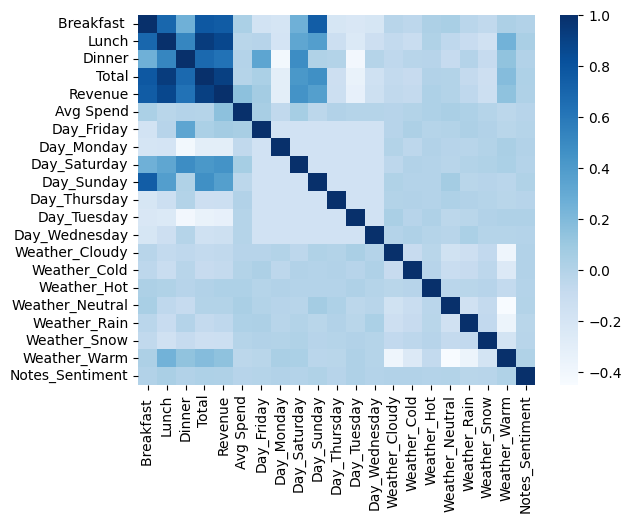

In [22]:
corr = data.corr()
sns.heatmap(corr, cmap="Blues")

From this correlation heatmap we can get some interesting insights:
*  There is a high correlation between Sundays and breakfasts, indicating people tend to go to the restaurant on **Sundays to have breakfast**.
*  There is a fairly high correlation between Fridays and dinners, indicating people tend to go to the restaurant on **Fridays to have dinner**.

## Incorporating accurate weather data

From Meteostat https://meteostat.net/en/.

1. Locating the closest weather station to Pomfret, CT (where the restaurant is located).

In [23]:
from meteostat import Stations, Daily

stations = Stations()
stations = stations.nearby(41.8976, -71.9626) # Pomfret, CT coordinates
station = stations.fetch(1)
station

name country region   wmo  icao  latitude  \
id                                                                           
KIJD0  Willimantic / Mansfield Hollow      US     CT  <NA>  KIJD    41.744   

       longitude  elevation          timezone hourly_start hourly_end  \
id                                                                      
KIJD0   -72.1802       75.0  America/New_York   2006-01-01 2024-04-26   

      daily_start  daily_end monthly_start monthly_end      distance  
id                                                                    
KIJD0  2006-01-01 2022-04-24    2006-01-01  2021-01-01  24836.502172

We can see here that the closest weather station is *Willimantic / Mansfield Hollow*, which is approximately 20 miles away from Pomfret, CT. **Daily weather data is available from January 1st, 2006**. 

In [24]:
daily = Daily('KIJD0') # Willimantic / Mansfield Hollow station
daily = daily.fetch()
daily # Temperatures are in Celsius

tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2006-01-01  -1.6  -2.8  -0.6   NaN   NaN    NaN   3.9   NaN     NaN   NaN
2006-01-02  -0.4  -3.9   2.2   3.8   NaN    NaN   0.5   NaN  1023.0   NaN
2006-01-03   0.5  -1.7   1.7   NaN   NaN    NaN  20.4   NaN     NaN   NaN
2006-01-04  -1.2  -3.3   0.6   0.0   NaN    NaN  10.3   NaN  1015.9   NaN
2006-01-05   0.2  -1.7   3.9   NaN   NaN    NaN   1.8   NaN     NaN   NaN
...          ...   ...   ...   ...   ...    ...   ...   ...     ...   ...
2024-04-27   8.9   0.0  16.7   0.4   NaN  227.0  10.5   NaN  1031.5   NaN
2024-04-28  12.3   6.0  21.1   6.7   NaN  198.0   7.0   NaN  1020.8   NaN
2024-04-29  16.9  10.6  25.6   1.8   NaN  357.0   8.7   NaN  1015.7   NaN
2024-04-30  11.8   9.5  15.6   1.5   NaN  113.0  10.5   NaN  1016.3   NaN
2024-05-01  10.2   6.9  15.6   6.7   NaN   81.0   9.1   NaN  1014.2   NaN

[6538 rows x 10 columns]

In [25]:
data = pd.concat([data, daily[['tavg', 'tmin', 'tmax', 'prcp', 'wspd']]], axis=1)

For now, let's only consider the data from 01/01/2006 to 31/12/2023.

In [26]:
data = data.loc[dt.datetime(2006,1,1):dt.datetime(2023,12,31)].fillna(0)
data

Breakfast   Lunch  Dinner  Total  Revenue  Avg Spend  Day_Friday  \
2006-01-01        21.0   45.0     0.0   66.0   748.53  11.341364         0.0   
2006-01-02        15.0  101.0     0.0  116.0  1325.58  11.427414         0.0   
2006-01-03         5.0   50.0     0.0   55.0   561.19  10.203455         0.0   
2006-01-04         7.0   86.0    29.0  122.0  1430.78  11.727705         0.0   
2006-01-05         8.0   92.0    43.0  143.0  1904.45  13.317832         0.0   
...                ...    ...     ...    ...      ...        ...         ...   
2023-12-27        43.0  138.0    13.0  194.0  3239.03  16.696031         0.0   
2023-12-28        26.0  154.0    21.0  201.0  3677.01  18.293582         0.0   
2023-12-29        30.0  154.0    17.0  201.0  3715.30  18.484080         1.0   
2023-12-30        56.0  149.0    28.0  233.0  4643.05  19.927253         0.0   
2023-12-31        88.0  105.0     0.0  193.0  3649.27  18.908135         0.0   

            Day_Monday  Day_Saturday  Day_Sunday  ...  Weather_Neutral  \
2006-01-01         0.0           0.0         1.0  ...              0.0   
2006-01-02         1.0           0.0         0.0  ...              1.0   
2006-01-03         0.0           0.0         0.0  ...              0.0   
2006-01-04         0.0           0.0         0.0  ...              0.0   
2006-01-05         0.0           0.0         0.0  ...              0.0   
...                ...           ...         ...  ...              ...   
2023-12-27         0.0           0.0         0.0  ...              0.0   
2023-12-28         0.0           0.0         0.0  ...              0.0   
2023-12-29         0.0           0.0         0.0  ...              0.0   
2023-12-30         0.0           1.0         0.0  ...              0.0   
2023-12-31         0.0           0.0         1.0  ...              0.0   

            Weather_Rain  Weather_Snow  Weather_Warm  Notes_Sentiment  tavg  \
2006-01-01           0.0           1.0           0.0           0.5719  -1.6   
2006-01-02           0.0           0.0           0.0           0.0000  -0.4   
2006-01-03           0.0           1.0           0.0           0.0000   0.5   
2006-01-04           0.0           0.0           0.0           0.0000  -1.2   
2006-01-05           0.0           0.0           1.0           0.0000   0.2   
...                  ...           ...           ...              ...   ...   
2023-12-27           1.0           0.0           0.0           0.0000   5.7   
2023-12-28           1.0           0.0           0.0           0.0000   7.7   
2023-12-29           1.0           0.0           0.0           0.0000   6.3   
2023-12-30           1.0           0.0           0.0           0.0000   4.9   
2023-12-31           0.0           0.0           0.0           0.0000   1.9   

            tmin  tmax  prcp  wspd  
2006-01-01  -2.8  -0.6   0.0   3.9  
2006-01-02  -3.9   2.2   3.8   0.5  
2006-01-03  -1.7   1.7   0.0  20.4  
2006-01-04  -3.3   0.6   0.0  10.3  
2006-01-05  -1.7   3.9   0.0   1.8  
...          ...   ...   ...   ...  
2023-12-27   3.3   8.3   1.2   1.2  
2023-12-28   5.6   8.9  24.7  15.3  
2023-12-29   5.0   7.2   1.5   3.7  
2023-12-30   1.7   6.7   0.0   8.4  
2023-12-31   1.1   2.8   0.0   9.3  

[6574 rows x 26 columns]

## Challenges

*  Applying NLP to the notes, since most of them are blank.
*  Dealing with days where the **restaurant was closed** (due to a holiday, construction, etc). This is important, since leaving these observations just in blank can be interpreted by the algorithm as days with very bad business performance, instead of considering that there were no operations at all.
*  Choosing the appropriate **sequence window length** for predictions. The sequence window is the final set of consecutive data points from the dataset that the model uses to make its first prediction. This is complicated, as we need to choose a window that is large enough to capture seasonalities, while being small enough to return accurate predictions.
*  Weather data incomplete (only from 01/01/2006).

## April 30 Forecasts

In [27]:
# Train/validation split (81 observations val size)
meals_uni = data['Total']
train_uni = meals_uni[dt.datetime(2001,6,30,0,0):dt.datetime(2023,10,11,0,0)]
val_uni = meals_uni[dt.datetime(2023,10,12,0,0):]

In [28]:
train_uni_31 = meals_uni[dt.datetime(2001,6,30,0,0):dt.datetime(2023,11,30,0,0)]
val_uni_31 = meals_uni[dt.datetime(2023,12,1,0,0):]

### ARIMA without intervention

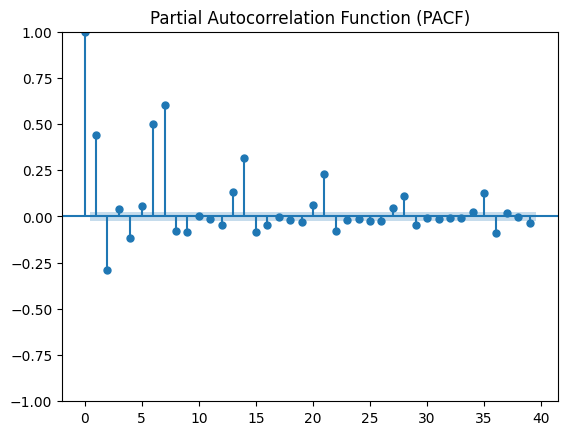

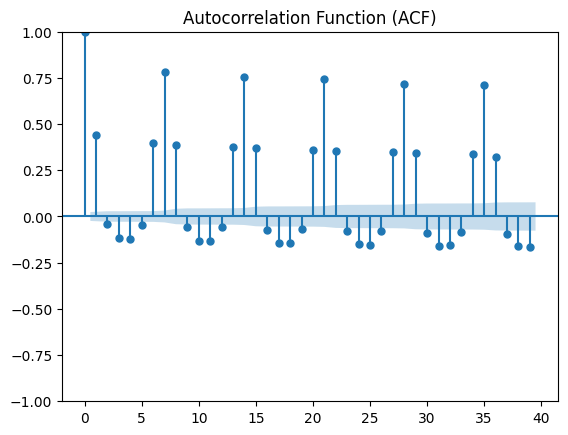

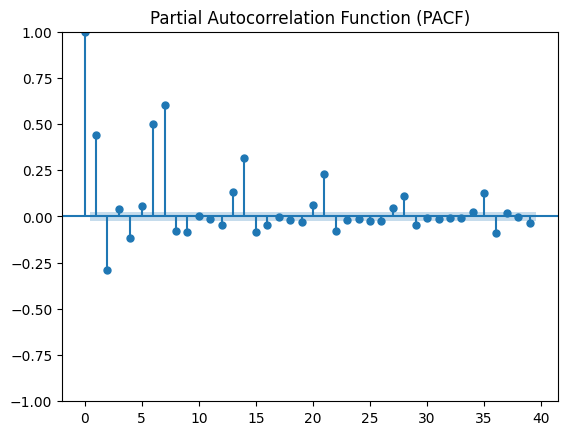

In [29]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_acf(meals_uni, title='Autocorrelation Function (ACF)')
plot_pacf(meals_uni, title='Partial Autocorrelation Function (PACF)')

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_uni_31, order=(2,1,5), seasonal_order=(1,1,1,7))
results = model.fit(maxiter=1000)
forecast = results.get_forecast(steps=31)
forecast_arima_noint = forecast.predicted_mean

mean_absolute_percentage_error(val_uni_31, forecast_arima_noint)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.64422D+00    |proj g|=  6.31364D-02

At iterate    5    f=  5.61282D+00    |proj g|=  5.17631D-03

At iterate   10    f=  5.61021D+00    |proj g|=  7.69989D-03

At iterate   15    f=  5.55970D+00    |proj g|=  7.14667D-02

At iterate   20    f=  5.54436D+00    |proj g|=  7.88784D-03

At iterate   25    f=  5.54421D+00    |proj g|=  1.36108D-03

At iterate   30    f=  5.54418D+00    |proj g|=  1.45363D-03

At iterate   35    f=  5.54418D+00    |proj g|=  6.77892D-04

At iterate   40    f=  5.54415D+00    |proj g|=  3.66104D-03

At iterate   45    f=  5.54409D+00    |proj g|=  1.73401D-03

At iterate   50    f=  5.54409D+00    |proj g|=  1.21564D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

0.28370761818603646

**Val size = 81**

*  order=(2,1,2), seasonal_order=(1,1,1,7) --> 0.4054
*  order=(2,0,2), seasonal_order=(1,1,1,7) --> 0.4444
*  order=(2,1,1), seasonal_order=(1,1,1,7) --> 0.4047
*  order=(1,1,1), seasonal_order=(1,1,1,7) --> 0.4054
*  order=(1,1,2), seasonal_order=(1,1,1,7) --> 0.5225

**Val size = 31**
*  order=(1,1,1), seasonal_order=(1,1,1,7) --> 0.3347

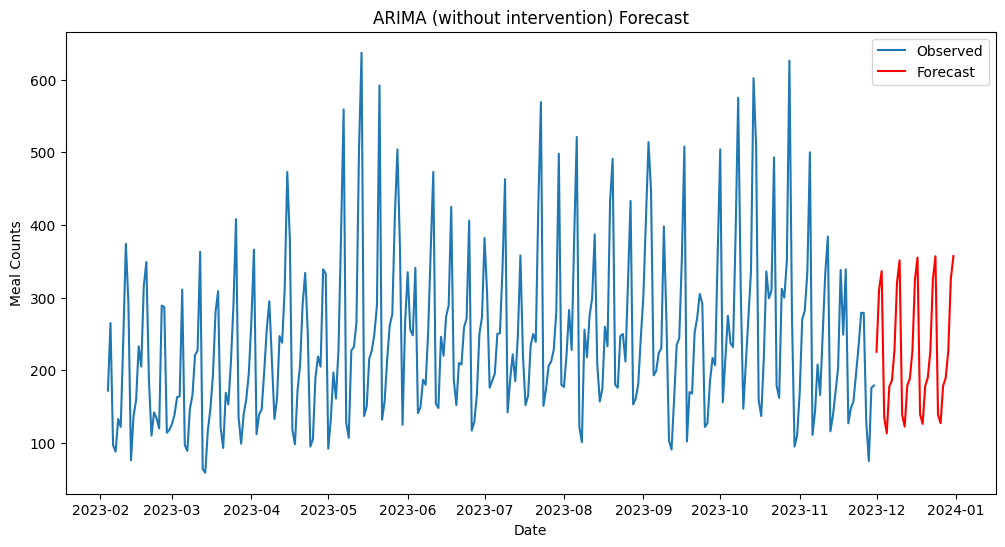

In [31]:
forecast_arima_noint.index = val_uni_31.index
plt.figure(figsize=(12, 6))
plt.plot(train_uni_31.iloc[-300:].index, train_uni_31.iloc[-300:], label='Observed') # Plot original data
plt.plot(forecast_arima_noint.index, forecast_arima_noint, label='Forecast', color='red') # Plot forecasted values
plt.title('ARIMA (without intervention) Forecast')
plt.xlabel('Date')
plt.ylabel('Meal Counts')
plt.legend()
plt.show()

### ARIMA with intervention

In [32]:
intervention = [1 if '2020-01-01' <= str(date) <= '2022-12-31' else 0 for date in train_uni_31.index]

model = SARIMAX(train_uni_31, order=(2,1,5), seasonal_order=(1,1,1,7), exog=intervention)
results = model.fit(maxiter=1000)
forecast = results.get_forecast(steps=31, exog=[0]*31)
forecast_arima_int = forecast.predicted_mean

mean_absolute_percentage_error(val_uni_31, forecast_arima_int)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.64422D+00    |proj g|=  6.31373D-02

At iterate    5    f=  5.61282D+00    |proj g|=  5.17653D-03

At iterate   10    f=  5.61022D+00    |proj g|=  7.13800D-03

At iterate   15    f=  5.56002D+00    |proj g|=  6.83422D-02

At iterate   20    f=  5.54470D+00    |proj g|=  2.19133D-02

At iterate   25    f=  5.54422D+00    |proj g|=  4.49994D-04

At iterate   30    f=  5.54418D+00    |proj g|=  8.63575D-04

At iterate   35    f=  5.54418D+00    |proj g|=  8.02385D-04

At iterate   40    f=  5.54413D+00    |proj g|=  4.90578D-03

At iterate   45    f=  5.54408D+00    |proj g|=  1.84436D-04

At iterate   50    f=  5.54408D+00    |proj g|=  7.51239D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

0.28399177344955817

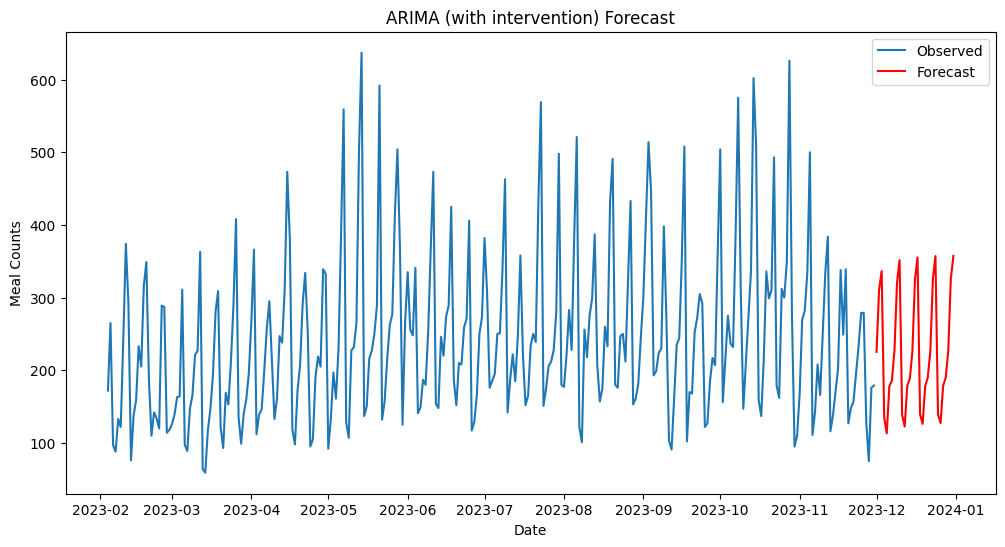

In [33]:
forecast_arima_int.index = val_uni_31.index
plt.figure(figsize=(12, 6))
plt.plot(train_uni_31.iloc[-300:].index, train_uni_31.iloc[-300:], label='Observed') # Plot original data
plt.plot(forecast_arima_int.index, forecast_arima_int, label='Forecast', color='red') # Plot forecasted values
plt.title('ARIMA (with intervention) Forecast')
plt.xlabel('Date')
plt.ylabel('Meal Counts')
plt.legend()
plt.show()

### Holt-Winters

In [34]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Model fitting + forecasting
model = ExponentialSmoothing(train_uni, 
                             trend='additive', 
                             seasonal='additive', 
                             seasonal_periods=365, 
                             initialization_method='heuristic')
results = model.fit(optimized=True,
                    remove_bias=False,
                    method='Powell')

# Forecast
forecast_expsmooth = results.forecast(81)
forecast_expsmooth.index = val_uni.index
forecast_expsmooth

2023-10-12    286.966486
2023-10-13    294.282417
2023-10-14    308.383391
2023-10-15    355.053079
2023-10-16    349.363519
                 ...    
2023-12-27    156.862472
2023-12-28    128.969281
2023-12-29    142.649443
2023-12-30    153.285461
2023-12-31    141.494719
Length: 81, dtype: float64

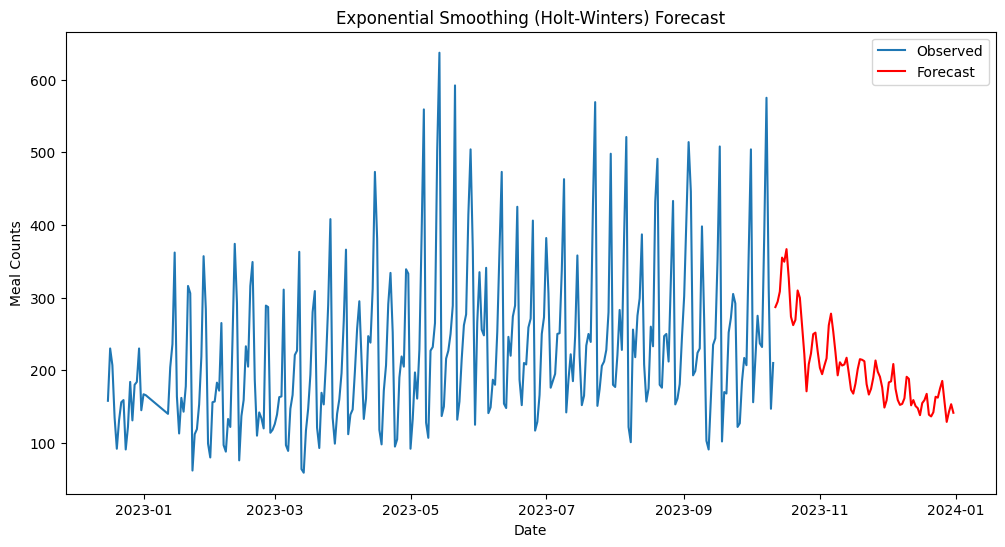

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(train_uni.iloc[-300:].index, train_uni.iloc[-300:], label='Observed') # Plot original data
plt.plot(forecast_expsmooth.index, forecast_expsmooth, label='Forecast', color='red') # Plot forecasted values
plt.title('Exponential Smoothing (Holt-Winters) Forecast')
plt.xlabel('Date')
plt.ylabel('Meal Counts')
plt.legend()
plt.show()

In [36]:
# Evaluation
mean_absolute_percentage_error(val_uni, forecast_expsmooth)

0.4259882825701384

### Neural Prophet

In [37]:
!pip install --upgrade neuralprophet pytorch-lightning

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/luxai2021-0.1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached pytorch_lightning-2.2.3-py3-none-any.whl.metadata (21 kB)


In [38]:
# Train/Val split
train_uni_np = pd.DataFrame(train_uni_31.reset_index()).rename(columns={"index": "ds", "Total": "y"})
val_uni_np = pd.DataFrame(val_uni_31.reset_index()).rename(columns={"index": "ds", "Total": "y"})

In [42]:
# Model fitting + forecasting
from neuralprophet import NeuralProphet, set_log_level

set_log_level("ERROR") # Disable logging messages unless there is an error

model = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False, 
    future_regressors_model='neural_nets',
    seasonality_reg=50,
    n_forecasts=14,
    future_regressors_num_hidden_layers=50,
    learning_rate=0.5,
    epochs=60,
    batch_size=2000,
    normalize='off',
    loss_func='MAE',
    optimizer='SGD'
)

# Train the model
model.fit(train_uni_np, freq='D', validation_df=val_uni_np)

# Forecast
future_dates = model.make_future_dataframe(train_uni_np, periods=31)
forecast = model.predict(future_dates)
forecast_values = forecast[["ds", "yhat1"]]

WARNING - (py.warnings._showwarnmsg) - UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 4it [00:00, ?it/s]

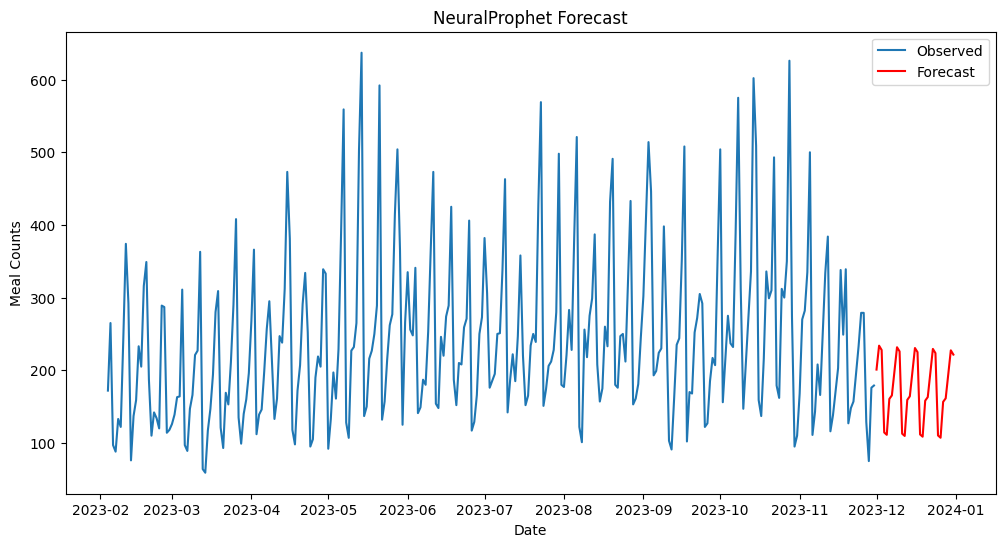

In [43]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_uni_np.iloc[-300:]['ds'], train_uni_np.iloc[-300:]['y'], label='Observed') # Plot original data
plt.plot(forecast['ds'], forecast['yhat1'], label='Forecast', color='red') # Plot forecasted values
plt.title('NeuralProphet Forecast')
plt.xlabel('Date')
plt.ylabel('Meal Counts')
plt.legend()
plt.show()

In [44]:
# Evaluation (MAPE)
forecast_np = forecast_values.set_index('ds')['yhat1']
true_np = val_uni_np.set_index('ds')['y']
mean_absolute_percentage_error(true_np, forecast_np)

0.1676641585967863

### N-BEATS

In [48]:
from NBEATS import NeuralBeats
import torch.optim

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=100, thetas_dim=4, backcast_length=7, forecast_length=81, share_thetas=False) at @11002446384
     | -- GenericBlock(units=100, thetas_dim=4, backcast_length=7, forecast_length=81, share_thetas=False) at @11014367968
     | -- GenericBlock(units=100, thetas_dim=4, backcast_length=7, forecast_length=81, share_thetas=False) at @11019158448
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=100, thetas_dim=8, backcast_length=7, forecast_length=81, share_thetas=False) at @10981738544
     | -- GenericBlock(units=100, thetas_dim=8, backcast_length=7, forecast_length=81, share_thetas=False) at @11019647936
     | -- GenericBlock(units=100, thetas_dim=8, backcast_length=7, forecast_length=81, share_thetas=False) at @11019636992


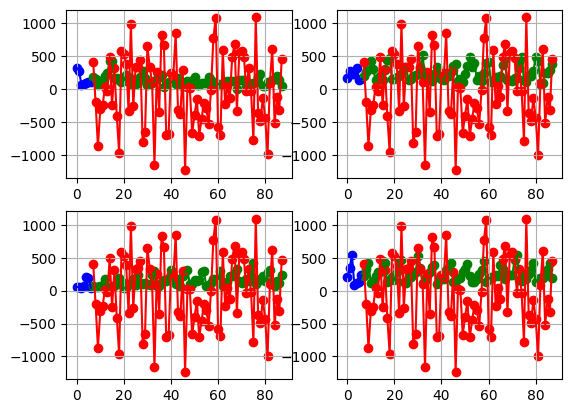

grad_step = 000030, tr_loss = 0.178617, te_loss = 0.545174
grad_step = 000060, tr_loss = 0.042365, te_loss = 0.545174
grad_step = 000090, tr_loss = 0.021295, te_loss = 0.545174


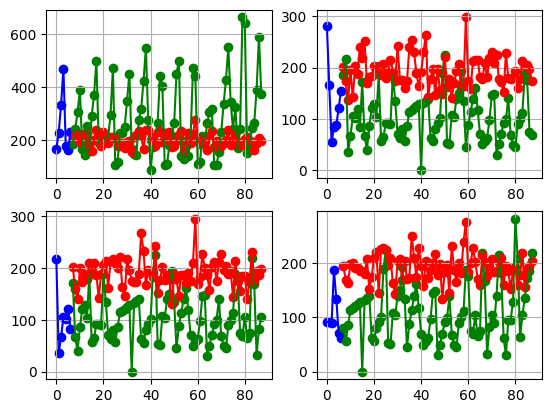

grad_step = 000120, tr_loss = 0.019770, te_loss = 0.018619
grad_step = 000150, tr_loss = 0.019099, te_loss = 0.018619
grad_step = 000180, tr_loss = 0.018195, te_loss = 0.018619


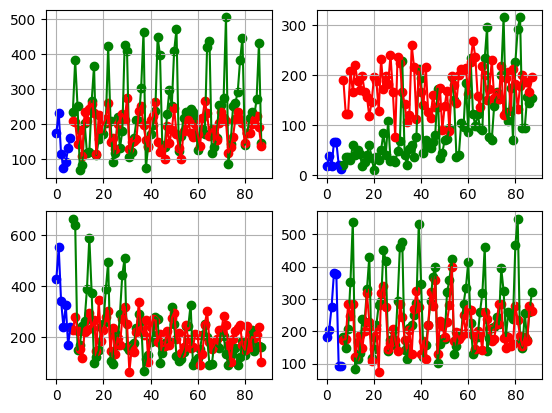

grad_step = 000210, tr_loss = 0.017069, te_loss = 0.016414
grad_step = 000240, tr_loss = 0.015854, te_loss = 0.016414
grad_step = 000270, tr_loss = 0.014894, te_loss = 0.016414
grad_step = 000300, tr_loss = 0.014153, te_loss = 0.016414


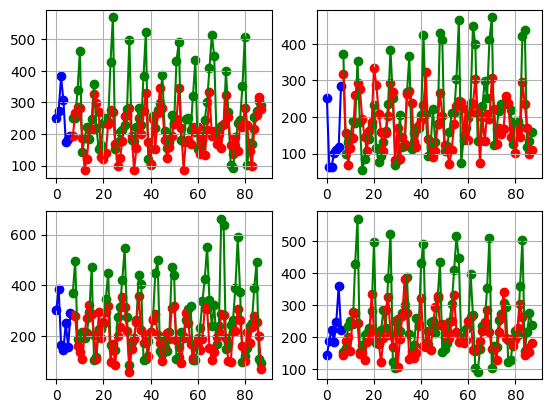

grad_step = 000330, tr_loss = 0.013509, te_loss = 0.014201
grad_step = 000360, tr_loss = 0.012998, te_loss = 0.014201
grad_step = 000390, tr_loss = 0.012586, te_loss = 0.014201


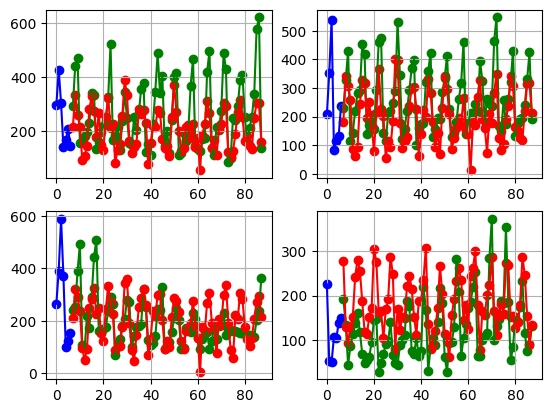

grad_step = 000420, tr_loss = 0.012250, te_loss = 0.013132
grad_step = 000450, tr_loss = 0.011985, te_loss = 0.013132
grad_step = 000480, tr_loss = 0.011777, te_loss = 0.013132


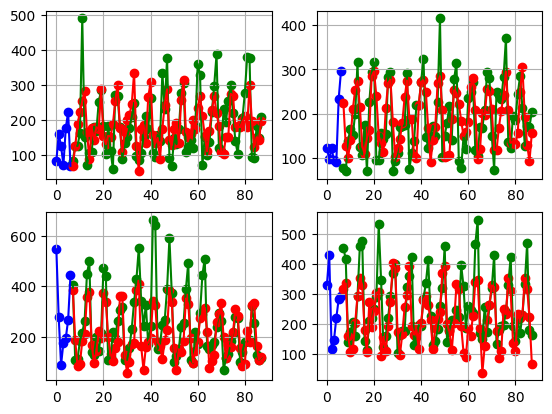

grad_step = 000510, tr_loss = 0.011564, te_loss = 0.012598
grad_step = 000540, tr_loss = 0.011406, te_loss = 0.012598
grad_step = 000570, tr_loss = 0.011262, te_loss = 0.012598
grad_step = 000600, tr_loss = 0.011145, te_loss = 0.012598


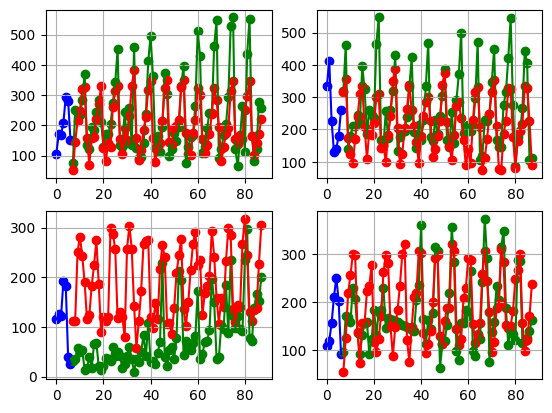

grad_step = 000630, tr_loss = 0.010999, te_loss = 0.012331
grad_step = 000660, tr_loss = 0.010875, te_loss = 0.012331
grad_step = 000690, tr_loss = 0.010763, te_loss = 0.012331


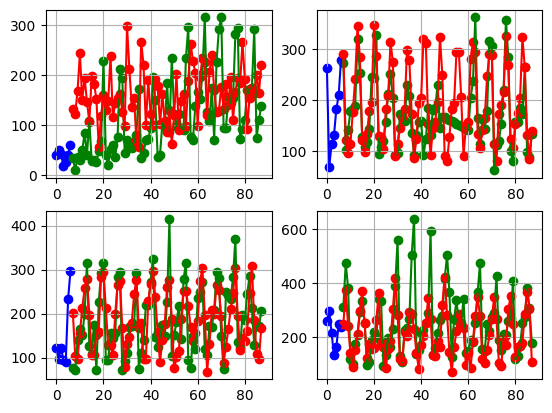

grad_step = 000720, tr_loss = 0.010635, te_loss = 0.011978
grad_step = 000750, tr_loss = 0.010536, te_loss = 0.011978
grad_step = 000780, tr_loss = 0.010427, te_loss = 0.011978


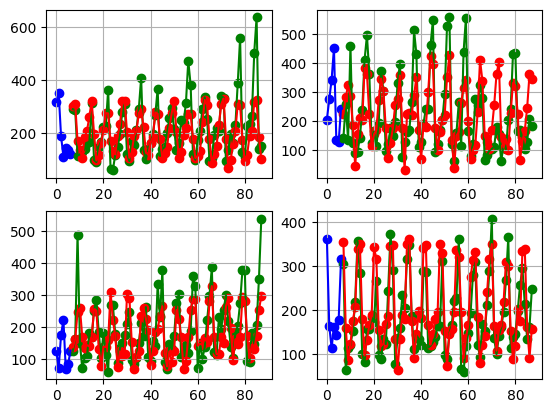

grad_step = 000810, tr_loss = 0.010318, te_loss = 0.011717
grad_step = 000840, tr_loss = 0.010183, te_loss = 0.011717
grad_step = 000870, tr_loss = 0.010086, te_loss = 0.011717
grad_step = 000900, tr_loss = 0.009965, te_loss = 0.011717


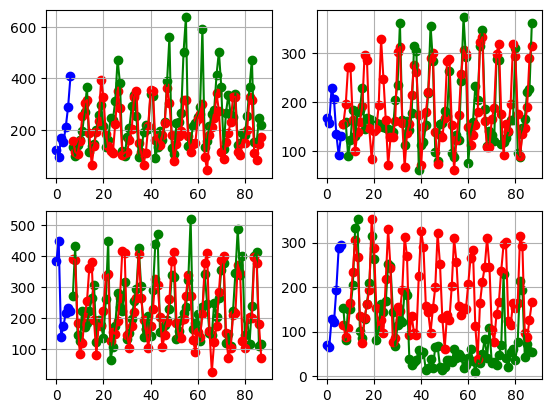

grad_step = 000930, tr_loss = 0.009839, te_loss = 0.011459
grad_step = 000960, tr_loss = 0.009743, te_loss = 0.011459
grad_step = 000990, tr_loss = 0.009728, te_loss = 0.011459


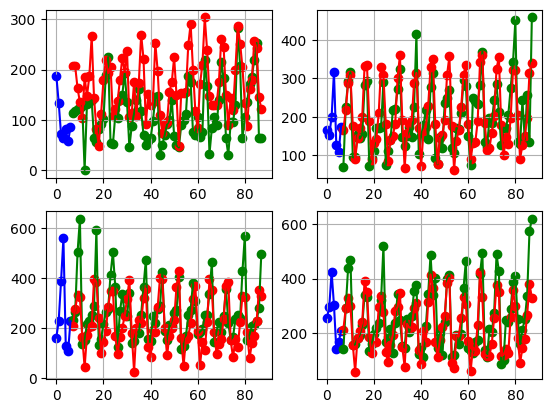

grad_step = 001020, tr_loss = 0.009527, te_loss = 0.011264
grad_step = 001050, tr_loss = 0.009443, te_loss = 0.011264
grad_step = 001080, tr_loss = 0.009352, te_loss = 0.011264


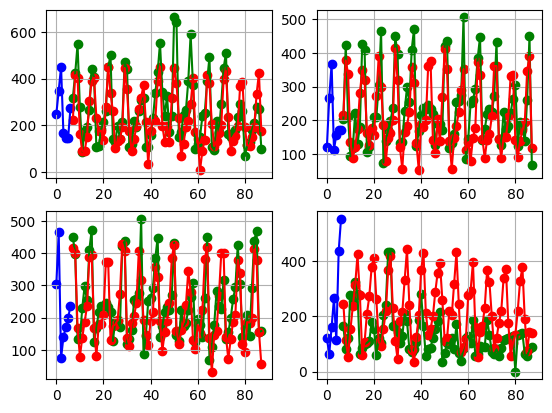

grad_step = 001110, tr_loss = 0.009291, te_loss = 0.011410
grad_step = 001140, tr_loss = 0.009217, te_loss = 0.011410
grad_step = 001170, tr_loss = 0.009095, te_loss = 0.011410
grad_step = 001200, tr_loss = 0.009006, te_loss = 0.011410


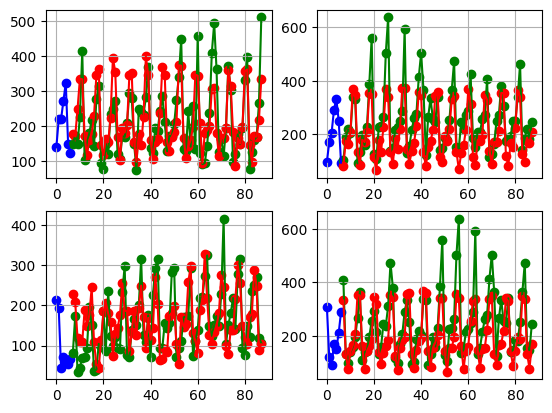

grad_step = 001230, tr_loss = 0.008946, te_loss = 0.010849
grad_step = 001260, tr_loss = 0.008883, te_loss = 0.010849
grad_step = 001290, tr_loss = 0.008847, te_loss = 0.010849


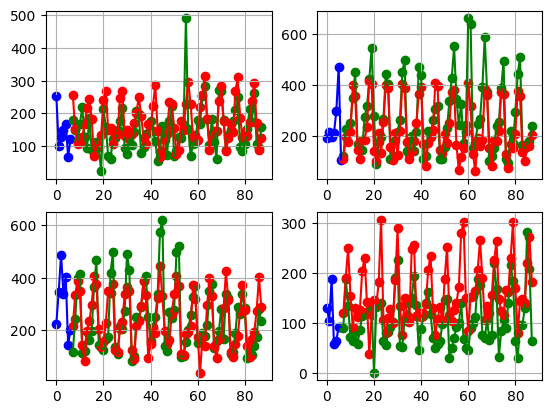

grad_step = 001320, tr_loss = 0.008770, te_loss = 0.010673
grad_step = 001350, tr_loss = 0.008723, te_loss = 0.010673
grad_step = 001380, tr_loss = 0.008647, te_loss = 0.010673


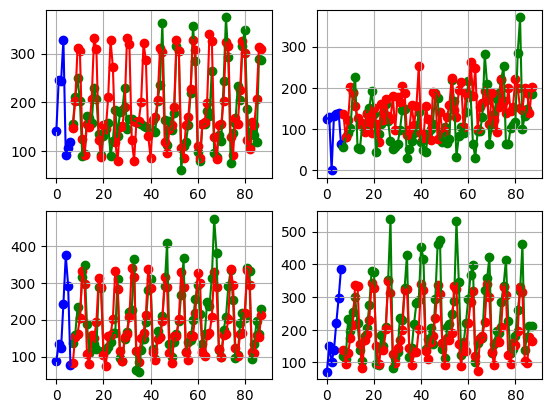

grad_step = 001410, tr_loss = 0.008701, te_loss = 0.010546
grad_step = 001440, tr_loss = 0.008541, te_loss = 0.010546
grad_step = 001470, tr_loss = 0.008500, te_loss = 0.010546
grad_step = 001500, tr_loss = 0.008500, te_loss = 0.010546


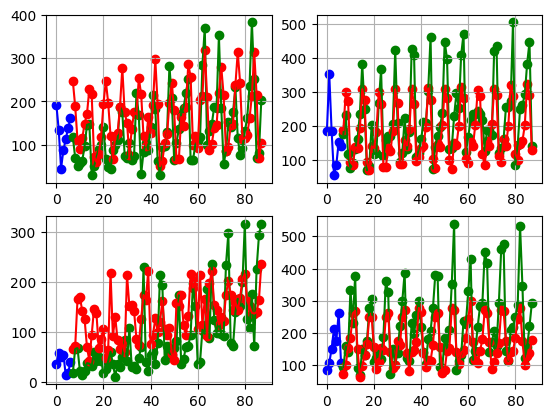

grad_step = 001530, tr_loss = 0.008415, te_loss = 0.010403
grad_step = 001560, tr_loss = 0.008380, te_loss = 0.010403
grad_step = 001590, tr_loss = 0.008366, te_loss = 0.010403


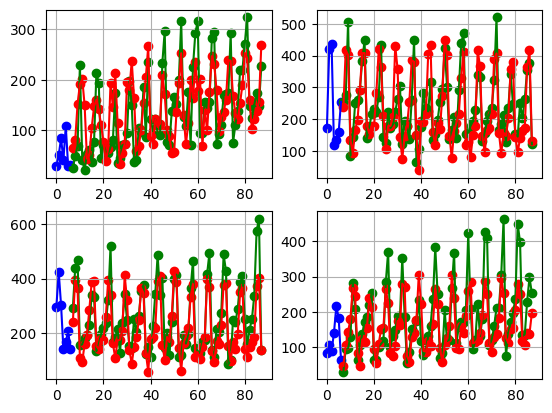

grad_step = 001620, tr_loss = 0.008366, te_loss = 0.010425
grad_step = 001650, tr_loss = 0.008306, te_loss = 0.010425
grad_step = 001680, tr_loss = 0.008265, te_loss = 0.010425


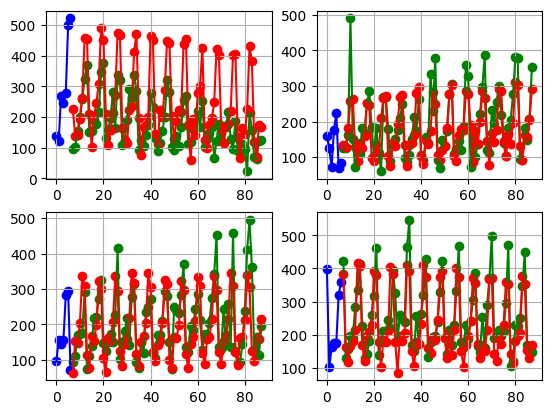

grad_step = 001710, tr_loss = 0.008293, te_loss = 0.010468
grad_step = 001740, tr_loss = 0.008178, te_loss = 0.010468
grad_step = 001770, tr_loss = 0.008185, te_loss = 0.010468
grad_step = 001800, tr_loss = 0.008138, te_loss = 0.010468


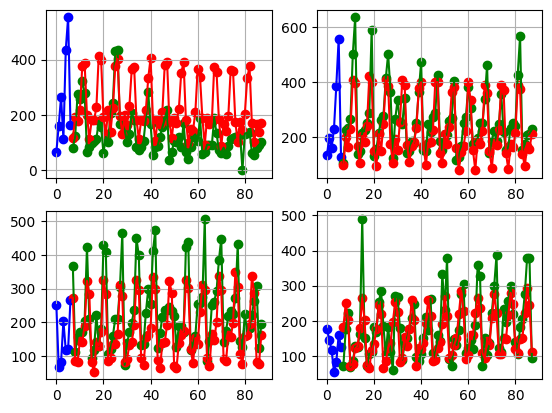

grad_step = 001830, tr_loss = 0.008150, te_loss = 0.010355
grad_step = 001860, tr_loss = 0.008097, te_loss = 0.010355
grad_step = 001890, tr_loss = 0.008119, te_loss = 0.010355


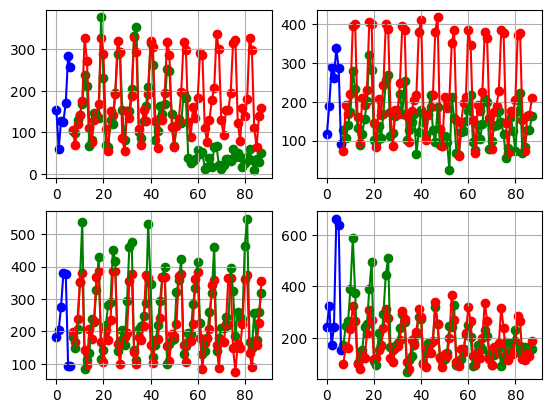

grad_step = 001920, tr_loss = 0.008124, te_loss = 0.010312
grad_step = 001950, tr_loss = 0.008098, te_loss = 0.010312
grad_step = 001980, tr_loss = 0.008054, te_loss = 0.010312


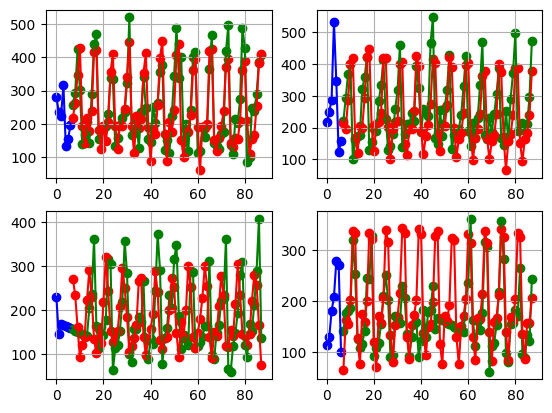

grad_step = 002010, tr_loss = 0.008014, te_loss = 0.010500
grad_step = 002040, tr_loss = 0.008010, te_loss = 0.010500
grad_step = 002070, tr_loss = 0.007912, te_loss = 0.010500
grad_step = 002100, tr_loss = 0.007961, te_loss = 0.010500


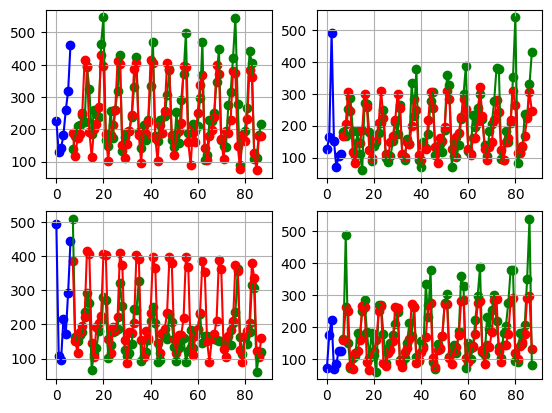

grad_step = 002130, tr_loss = 0.007877, te_loss = 0.010456
grad_step = 002160, tr_loss = 0.007919, te_loss = 0.010456
grad_step = 002190, tr_loss = 0.007926, te_loss = 0.010456


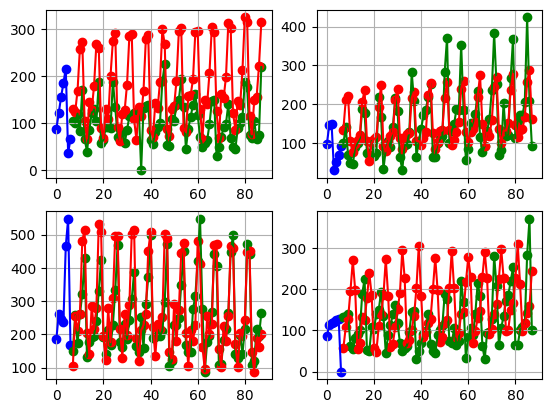

grad_step = 002220, tr_loss = 0.007837, te_loss = 0.010543
grad_step = 002250, tr_loss = 0.007921, te_loss = 0.010543
grad_step = 002280, tr_loss = 0.007838, te_loss = 0.010543


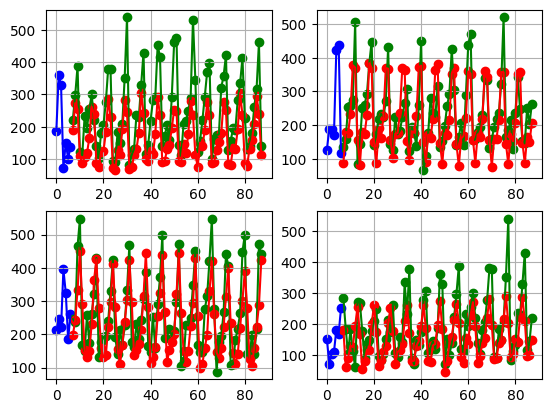

grad_step = 002310, tr_loss = 0.007801, te_loss = 0.010414
grad_step = 002340, tr_loss = 0.007898, te_loss = 0.010414
grad_step = 002370, tr_loss = 0.007740, te_loss = 0.010414
grad_step = 002400, tr_loss = 0.007739, te_loss = 0.010414


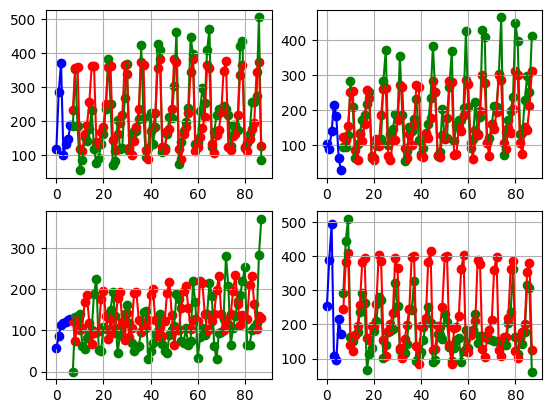

grad_step = 002430, tr_loss = 0.007753, te_loss = 0.010544
grad_step = 002460, tr_loss = 0.007733, te_loss = 0.010544
grad_step = 002490, tr_loss = 0.007745, te_loss = 0.010544


In [96]:
train_uni_nbeats_31 = train_uni_31.values.reshape([-1,1])       # (nx1 array)

model = NeuralBeats(data=train_uni_nbeats_31, forecast_length=81, backcast_length=7, batch_size=2000, hidden_layer_units=100)
model.fit(optimiser=torch.optim.AdamW(model.parameters, lr=0.001, betas=(0.9, 0.999), eps=1e-07, weight_decay=0.01))

In [97]:
forecast = model.predict()
avg_forecast = np.mean(forecast, axis=1)
avg_forecast

array([201.15529, 197.19011, 201.1346 , 201.23271, 200.2207 , 193.41626,
       197.41077, 197.49641, 192.10353, 198.24081, 202.67856, 199.7113 ,
       195.31548, 198.75237, 201.68242, 194.90417, 202.52869, 200.9953 ,
       198.7639 , 194.2127 , 198.10973, 196.85667, 194.5487 , 198.73055,
       200.61334, 195.36627, 191.45337, 199.06903, 199.56535, 198.18884,
       198.9274 , 202.24165, 197.2269 , 195.4101 , 196.5169 , 194.92963,
       195.81206, 199.55771, 198.92601, 197.59476, 195.44496, 201.71207,
       197.57585, 192.22607, 199.53317, 199.97887, 201.94446, 194.27539,
       196.87656, 198.27141, 195.37492, 202.25476, 202.45084, 198.66458,
       194.51321, 198.83578, 196.66296, 195.03758, 196.69975, 202.46043,
       198.78764, 191.78023, 199.61774, 196.17062, 195.26768, 198.55351,
       199.3797 , 197.59486, 191.82379, 199.10127, 198.01001, 195.0302 ,
       197.35043, 198.71228, 197.2419 , 194.74701, 196.60268, 196.75665,
       192.60767, 197.51982, 200.94595], dtype=floa

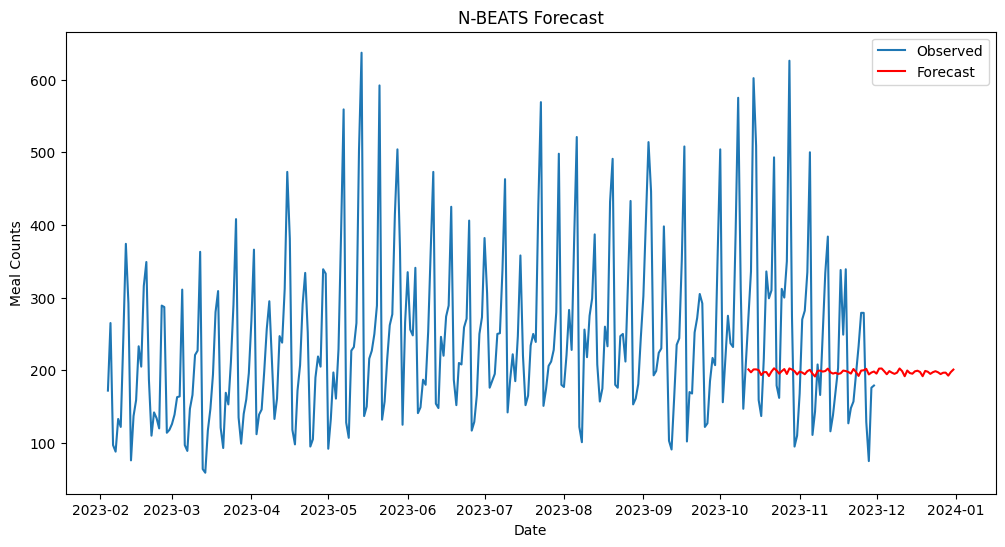

In [98]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_uni_np.iloc[-300:]['ds'], train_uni_np.iloc[-300:]['y'], label='Observed') # Plot original data
plt.plot(val_uni.index, avg_forecast, label='Forecast', color='red') # Plot forecasted values
plt.title('N-BEATS Forecast')
plt.xlabel('Date')
plt.ylabel('Meal Counts')
plt.legend()
plt.show()

In [99]:
mean_absolute_percentage_error(avg_forecast, np.array(val_uni))

0.4051025900890263

### LSTM

In [ ]:
df = train_uni_np.values.astype(float).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1)) #data scaling
data_normalized = scaler.fit_transform(df)
data_normalized = torch.FloatTensor(data_normalized).view(-1)

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    
    return np.array(xs), np.array(ys)

seq_length = 7
X, y = create_sequences(data_normalized, seq_length)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

# Reshaping the input data to [samples, time steps, features]
X = X.reshape(X.shape[0], seq_length, -1)  # Adding the features dimension

# Creainge training and test sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# Defining the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

model = LSTM(input_size=1, hidden_layer_size=100, output_size=1)
loss_function = nn.MSELoss() #Mean Squared Error losss
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3) # Adam optimizer

# Preparing DataLoader for batch processing
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=64)

# Training loop
model.train()
for epoch in range(75):  # Adjust the number of epochs as needed
    for seq, labels in train_loader:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels.view(-1, 1))
        single_loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'epoch: {epoch} loss: {single_loss.item()}')

# Testing loop
model.eval()
with torch.no_grad():
    preds = model(X_test)
    loss = loss_function(preds, y_test.view(-1, 1))
    print(f'Test loss (MSE): {loss.item()}')

In [ ]:
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_backtest_metrics
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

# Step 1: Load your data
data = data[['Total']]  # Use only the relevant column

# Step 2: Convert data into a format compatible with GluonTS
training_data = ListDataset([
    {
        "start": data.index[0],
        "target": data['Total'].values
    }
], freq='D')  # Change 'D' to the frequency of your time series

# Step 3: Initialize the model
estimator = DeepAREstimator(freq='D', prediction_length=31, trainer=Trainer(epochs=20))

# Step 4: Train the model
predictor = estimator.train(training_data)

# Step 5: Forecast
future_dates = 31  # Number of periods to forecast
forecast_it, ts_it = make_backtest_metrics(predictor, training_data, num_windows=1, window_size=future_dates)

# Step 6: Evaluate the forecast
evaluator = Evaluator(quantiles=[0.5])
agg_metrics, item_metrics = evaluator(ts_it, forecast_it)

print(agg_metrics)


## April 29 Forecasts

In [ ]:
meals = data['Total']
meals

In [ ]:
meals

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Assuming 'time_series' is your time series data in a Pandas Series format.
# Let's say it's a monthly series:
# time_series = pd.Series(..., index=pd.date_range(..., freq='M'))

# 1. Differencing (Optional): For regular or seasonal differencing:
def difference(data, n_diff=1, n_seasonal_diff=0, seasonal_periods=12):
    for _ in range(n_diff):
        data = data.diff().dropna()

    if n_seasonal_diff > 0:
        for _ in range(n_seasonal_diff):
            data = data.diff(seasonal_periods).dropna()

    return data

# Example usage:
differenced_series = difference(meals, n_diff=1, n_seasonal_diff=1, seasonal_periods=12)

# 2. Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
time_series_scaled = scaler.fit_transform(differenced_series.values.reshape(-1, 1))

# 3. Convert time series to supervised learning format
def series_to_supervised(data, n_lags=1, n_forecasts=1):
    X, y = [], []
    for i in range(len(data) - n_lags - n_forecasts + 1):
        X.append(data[i:i+n_lags])
        y.append(data[i+n_lags:i+n_lags+n_forecasts])
    return np.array(X), np.array(y)

# Set number of lags and forecasts
n_lags = 4  # Number of past time steps to use as features
n_forecasts = 1  # Number of steps to forecast

X, y = series_to_supervised(time_series_scaled, n_lags, n_forecasts)

# 4. Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 5. Reshape X_train and X_test to be 3D: (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], n_lags, 1))
X_test = X_test.reshape((X_test.shape[0], n_lags, 1))


In [ ]:
differenced_series.plot()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_lags, 1)),
    Dense(n_forecasts)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)

# Rescale predictions and actuals back to original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Error metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)

print(f'MAE: {mae}')
print(f'MAPE: {mape}')

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label='Actual')
plt.plot(range(len(y_pred_rescaled)), y_pred_rescaled, label='Predicted')
plt.legend()
plt.title('LSTM Predictions vs Actuals')
plt.show()

### DarTS

In [ ]:
from darts import TimeSeries

**Preparing the time series**

In [ ]:
meals = data[['Total']].reset_index()
series = TimeSeries.from_dataframe(meals, 'index', 'Total', freq='D')
series

**Train/Validation datasets**

In [ ]:
# Set aside the last 36 months as a validation series
train, val = series[:-14], series[-14:]

**LSTM**

In [ ]:
from darts.datasets import WeatherDataset

series = WeatherDataset().load()
# predicting atmospheric pressure
target = series['p (mbar)'][:100]
# optionally, use future temperatures (pretending this component is a forecast)
future_cov = series['T (degC)'][:106]
series

In [ ]:
# `training_length` > `input_chunk_length` to mimic inference constraints
model = RNNModel(
    model="RNN",
    input_chunk_length=6,
    training_length=18,
    n_epochs=5,
)
model.fit(target, future_covariates=future_cov)
pred = model.predict(6)
pred.values()

In [ ]:
from darts.models import RNNModel

model = RNNModel(
    model="RNN",
    input_chunk_length=14,
    training_length=28,
    n_epochs=5
)

model.fit(train)
pred = model.predict(14)
pred.values()

In [ ]:
val

## Basic Forecasting

#### DarTS

In [ ]:
!pip3 install darts

In [ ]:
from darts import TimeSeries
from darts.datasets import AirPassengersDataset

In [ ]:
data.reset_index()['time']

In [ ]:
series = TimeSeries.from_dataframe(data[['Total']], fill_missing_dates=True, freq=None)
series

In [ ]:
train, val = series.split_before(pd.Timestamp("20231129"))
train.plot(label="training")
val.plot(label="validation")

In [ ]:
train.values()

In [ ]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta
from darts.metrics import mape

def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))

#eval_model(ExponentialSmoothing())
#eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

After performing an EDA, we can now proceed to perform some basic forecasting in our (now well processed) time series dataset. We will focus on predicting the **short-term demand of daily meals**. As such, variable `Total` will be the target value in the models to be built here.

### Auto-Regressive Integrated Moving Average (ARIMA)

In [ ]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

I will use the `auto_arima` function from the `pmdarima` package to **automatically estimate the proper order** of the ARIMA model we will fit afterwards.

In [ ]:
arima_order = auto_arima(data['Total'], seasonal=True, trace=True)

This returned the best ARIMA model to be that of **order (2,1,5)**. We will therefore fit it with the `ARIMA` function from `statsmodels`.

In [ ]:
# Fit the ARIMA(2,0,0) model
data = data.asfreq('D')
model = ARIMA(data['Total'], order=(2, 1, 5), dates=data.index)
results = model.fit()
print(results.summary())

The ARIMA(2, 1, 5) model output indicates that all AR and MA coefficients are statistically significant, suggesting a good fit to the data. The model's log likelihood is high, and the AIC, BIC, and HQIC values is low but could be lowered. The Ljung-Box test shows a significant p-value (0.00), indicating potential autocorrelation in residuals. The Jarque-Bera test result is significant, which, along with a kurtosis of 4.52, suggests that the residuals might not be normally distributed. Overall, the model fits well, but the residuals' behavior might need further investigation.

However, the ARIMA model **does not take into account exogenous variables** (such as the weather, the day of the week, or notes) to forecast the total count of meals to be served. To address this, I will try other models that can incorporate exogenous variables, including neural networks.

### SARIMAX

Some variables ('Revenue', 'Breakfast ', 'Lunch', 'Dinner') do not have to be taken into account in our model as exogenous variables because they are **totally dependent on the target variable** ('Total'). Therefore they will be removed from the exogenous variables to be evaluated by the model so as to prevent overflowing the training dataset.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Set the date index frequency to daily mode 
#data.index = data.index.to_period('D') 

# Prepare the exogenous variables
exog_train = data[['Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
             'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday', 'Notes_Sentiment', 'tavg']].values.tolist()  # Drop 'Revenue'/'Brekfast'/'Lunch'/'Dinner' as they are dependent variables

# SARIMAX model for predicting the daily temp for the next 14 days
model = SARIMAX(data['Total'], order=(2,1,0), seasonal_order=(1,1,1,7), exog = exog_train)
results = model.fit(disp=False)
forecast = results.get_forecast(steps=14).predicted_mean
forecast = pd.DataFrame(forecast)

IMP! you need to provide additional exogenous values corresponding to the steps you want to predict. This is because the SARIMAX model you have fitted includes exogenous variables, and to forecast future values, the model requires future values for these exogenous variables as well.

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

# Prepare the target variable 'Total'
y = data['Total']

# Prepare the exogenous variables
exog = data.drop(['Total', 'Revenue', 'Breakfast ', 'Lunch', 'Dinner'], axis=1)  # Drop 'Revenue'/'Brekfast'/'Lunch'/'Dinner' as they are dependent variables

# Define the rolling forecast procedure
history_endog = y.dropna().tolist()  # Endogenous variable (target)
history_exog = exog.dropna().values.tolist()  # Exogenous variables

# Here we should take care of splitting the exogenous variables in the same manner as the endogenous variable
predictions = []
true_values = []

# Number of steps to forecast
steps = 14
window_size = len(y) - steps  # Set up the initial window size

# Walk-forward validation
for t in range(steps):
    # Slice the historical data up to the split point
    train_endog = history_endog[:-steps+t]
    train_exog = history_exog[:-steps+t]

    # Fit the model
    model = SARIMAX(train_endog, order=(5,1,0), seasonal_order=(1,1,1,7), exog=train_exog)
    model_fit = model.fit(disp=False)
    # Forecast one step ahead
    output = model_fit.forecast(exog=[history_exog[len(train_endog)]])
    predictions.append(output[0])

    # The true value to be predicted
    true = history_endog[len(train_endog)]
    true_values.append(true)

# Calculate the Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(true_values, predictions)
print('MAPE: %.3f' % mape)

# Time series cross-validation for SARIMAX with exogenous variables
tscv = TimeSeriesSplit(n_splits=5)
error_scores = []

for train_index, test_index in tscv.split(y):
    train_endog, test_endog = y.iloc[train_index], y.iloc[test_index]
    train_exog, test_exog = exog.iloc[train_index], exog.iloc[test_index]

    # Fit the model on training data
    model = SARIMAX(train_endog, order=(5,1,0), seasonal_order=(1,1,1,7), exog=train_exog)
    model_fit = model.fit(disp=False)
    # Forecast the test dataset
    predictions = model_fit.get_forecast(steps=len(test_endog), exog=test_exog).predicted_mean

    # Calculate MAPE for each fold
    fold_mape = mean_absolute_percentage_error(test_endog, predictions)
    error_scores.append(fold_mape)

print('Cross-validation MAPE scores:', error_scores)
print('Mean CV MAPE: %.3f' % np.mean(error_scores))


#### Evaluation

*  **Holdout testing**: Training dataset goes from 01/01/2006 until 11/29/2023, and test dataset goes from 11/30/2023 to 12/31/2023.

In [ ]:
train_data = data[dt.datetime(2006,1,1,0,0):dt.datetime(2023,11,30,0,0)]
test_data = data[dt.datetime(2023,11,30,0,0):][['Total']]

# SARIMAX model for predicting the daily temp for the next 32 days from the holdout period
model = SARIMAX(train_data['Total'], order=(5,1,0), seasonal_order=(1,1,1,7))
results = model.fit(disp=False)
forecast = results.get_forecast(steps=32).predicted_mean
forecast = pd.DataFrame(forecast)

In [ ]:
print('There is a correlation of ', forecast['predicted_mean'].corr(test_data['Total']), 'between the predicted and true total meal counts.')
pd.concat([forecast, test_data], axis=1)

In [ ]:
# Convert (now in period format) date indices back to datetime
forecast.index = forecast.index.to_timestamp()
test_data.index = test_data.index.to_timestamp()

# Plot each column as a line on the same graph
plt.plot(forecast.index, forecast['predicted_mean'], label='Predicted')
plt.plot(test_data.index, test_data['Total'], label='True')
plt.title('Predicted vs. True Total Meal Counts')
plt.xlabel('Date')
plt.ylabel('Meal Counts')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

*  **Mean Absolute Percentage Error (MAPE)**

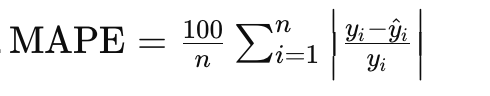

In [ ]:
from datetime import datetime
forecast.iloc[6541:6571]

In [ ]:
y_pred = forecast.iloc[6541:6571]['yhat1']
y_true = forecast.iloc[6541:6571]['y']
rmse(y_pred, y_true)

In [ ]:
# Function to calculate MAPE
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [ ]:
mape(y_pred, y_true)

In [ ]:
def rmse(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_pred - y_true)**2))

In [ ]:
rmse(y_pred, y_true)

### Long Short-Term Memory (LSTM)

I will now proceed to apply the first deep learning algorithm, LSTMs. **Long Short-Term Memory networks**, or LSTMs, are a special kind of recurrent neural network (RNN) capable of learning long-term dependencies. They are particularly useful for sequence prediction problems due to their ability to retain information over extended time intervals through their internal gating mechanism, which regulates the flow of information. In the context of this project, it is suitable to predict short-term demand in a restaurant by learning from historical sales data, considering patterns such as seasonality, trends, and other cyclic behaviors over time.

I will use the L1 Loss as evaluation metric. PyTorch's `nn.L1Loss` creates a criterion that measures the mean absolute error (MAE) between each element in the input x and target y.

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
df = data['Total'].values.astype(float).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(df)
data_normalized = torch.FloatTensor(data_normalized).view(-1)

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    
    return np.array(xs), np.array(ys)

seq_length = 14 # final set of consecutive data points from the dataset that the LSTM model needs to make its first prediction
X, y = create_sequences(data_normalized, seq_length)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

# Reshaping the input data to [samples, time steps, features]
X = X.reshape(X.shape[0], seq_length, -1)  # Adding the features dimension

# Creainge training and test sets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# Defining the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

model = LSTM(input_size=1, hidden_layer_size=100, output_size=1)
loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)

# Preparing DataLoader for batch processing
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=64)

# Training loop
model.train()
for epoch in range(40):  # Adjust the number of epochs as needed
    for seq, labels in train_loader:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels.view(-1, 1))
        single_loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'epoch: {epoch} loss: {single_loss.item()}')

# Testing loop
model.eval()
with torch.no_grad():
    preds = model(X_test)
    loss = loss_function(preds, y_test.view(-1, 1))
    print(f'Test loss: {loss.item()}')

In [ ]:
model.eval()  # Switch to evaluation mode

# Initialize the sequence with the last `seq_length` data points from the training data
current_seq = data_normalized[-seq_length:].tolist()

# Store the predictions
predictions = []

# Predict the next 14 days
for _ in range(14):
    with torch.no_grad():
        # Convert sequence to a tensor suitable for LSTM input
        seq_tensor = torch.FloatTensor(current_seq).view(-1, seq_length, 1)
        # Get the prediction for the next day
        pred = model(seq_tensor)
        # Extract the prediction value (as a float) and add it to the list of predictions
        pred_value = pred.item()
        predictions.append(pred_value)
        # Update the sequence to include the new prediction and drop the first value
        current_seq.append(pred_value)
        current_seq = current_seq[1:]

# The predictions are in the normalized scale. You need to inverse the scaling to obtain the original scale of the data.
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).reshape(-1)
predictions

In [ ]:
# Assuming model, X_test, and y_test are defined as before
model.eval()
with torch.no_grad():
    # Predict for the test set
    y_pred_test = model(X_test)
    
# Inverse scale the predictions
y_pred_test = scaler.inverse_transform(y_pred_test.detach().numpy()).reshape(-1)

# Inverse scale the true y values of the test set
y_true_test = scaler.inverse_transform(y_test.detach().numpy().reshape(-1, 1)).reshape(-1)

# Extract the corresponding dates for the test set predictions
# We are assuming that your data has been split such that the last `test_size` entries correspond to the test set
test_dates = pd.to_datetime(data.index[-test_size:])

# Construct a DataFrame with the observed and predicted values
comparison_df = pd.DataFrame({
    'Date': test_dates,
    'Observed': y_true_test,
    'Predicted': y_pred_test
})

# If you want to limit the DataFrame to the first 30 predictions only
comparison_df = comparison_df.head(30)

# Display or save the DataFrame
comparison_df
# To save the DataFrame to CSV
#comparison_df.to_csv("/mnt/data/observed_vs_predicted.csv", index=False)


In [ ]:
rmse(comparison_df['Predicted'], comparison_df['Observed'])

In [ ]:
loss.item()

In [ ]:
# Initialize the sequence with the last 5 days of 2023
last_seq = data_normalized[-5:]  # Last 5 days from the normalized data
last_seq = torch.FloatTensor(last_seq).view(1, seq_length, -1)  # Reshape for the model

# Predict the next 14 days
model.eval()  # Ensure the model is in evaluation mode
predictions = []

for _ in range(14):  # Forecast the next 14 days
    with torch.no_grad():
        # Predict the next step and retrieve numpy value
        pred = model(last_seq)
        predictions.append(pred.numpy().flatten()[0])  # Store prediction
        # Update the sequence with the new prediction
        last_seq = torch.cat((last_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)

# Inverse transform to get back to the original scale
predictions = np.array(predictions)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Prepare the date range for the last 4 weeks of historical data
data = data.reset_index()
last_4_weeks_mask = data['Date'] >= (data['Date'].iloc[-1] - pd.Timedelta(weeks=4))
last_4_weeks_data = data[last_4_weeks_mask]
last_4_weeks_dates = last_4_weeks_data['Date']
last_4_weeks_values = last_4_weeks_data['Total']

# Prepare the date range for your predictions
prediction_dates = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=14)

# Plotting
plt.figure(figsize=(12, 6))

# Plot the last 4 weeks of historical data
plt.plot(last_4_weeks_dates, last_4_weeks_values, label='Historical Data', color='blue')

# Plot the predicted data, with dates on the x-axis
plt.plot(prediction_dates, predictions, label='Forecasted Data', color='red', linestyle='--')

# Formatting the x-axis with date labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # to show every day
plt.gcf().autofmt_xdate()  # to format the date labels for better readability

# Final plot formatting
plt.title('Time Series Forecast for the Last 4 Weeks and 14 Days Ahead')
plt.xlabel('Date')
plt.ylabel('Total Value')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Assuming 'data' is your DataFrame with a 'Date' column and 'Total' values
# Make sure your DataFrame is sorted by date

# Slice the last 4 weeks of historical data
four_weeks = 4 * 7  # 4 weeks * 7 days per week
historical_slice = data['Total'][-(four_weeks+1):-1]  # Exclude the last day to append predictions
date_slice = pd.to_datetime(data.index[-(four_weeks+1):-1])  # Corresponding dates

# Concatenate the historical dates and prediction dates
prediction_dates = pd.date_range(start=date_slice[-1] + pd.Timedelta(days=1), periods=14)
all_dates = date_slice.union(prediction_dates)

# Concatenate the historical data and predictions
all_values = historical_slice.tolist() + prediction_dates.tolist()

# Plot the last 4 weeks of historical data
plt.figure(figsize=(10, 5))
plt.plot(all_dates[:four_weeks], all_values[:four_weeks], label='Historical Data', color='blue')

# Plot the 14 days of predictions
plt.plot(all_dates[-14:], all_values[-14:], label='Forecasted Data', color='red', linestyle='--')

# Formatting the x-axis to show dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # to show every day
plt.gcf().autofmt_xdate()  # Rotation

# Final plot formatting
plt.title('Time Series Forecast for the Last 4 Weeks and 14 Days Ahead')
plt.xlabel('Date')
plt.ylabel('Total Value')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
data

In [ ]:
from sklearn.metrics import mean_squared_error

# Naive forecast: the forecast for each point is the actual value of the previous point
y_naive_forecast = y_test[1:]  # Shift the test set to create the naive forecast
y_naive_truth = y_test[:-1]  # Remove the first element that we don't have a forecast for
mse_naive = mean_squared_error(y_naive_truth, y_naive_forecast)
print(f'Naive Forecast MSE: {mse_naive}')

# Mean forecast: the forecast for each point is the mean of the target variable in the training set
y_mean_forecast = np.full_like(y_test, y_train.mean())
mse_mean = mean_squared_error(y_test, y_mean_forecast)
print(f'Mean Forecast MSE: {mse_mean}')

# Compare MSE with the baseline models
print(f'Model MSE: {loss.item()}')  # loss from your model's test predictions
print(f'Is the model better than the naive forecast? {"Yes" if loss.item() < mse_naive else "No"}')
print(f'Is the model better than the mean forecast? {"Yes" if loss.item() < mse_mean else "No"}')

In [ ]:
loss.item()

LSTM with all variables:

In [ ]:
# Normalize the entire dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data)
data_normalized = torch.FloatTensor(data_normalized)

# Function to create time sequences (for the loss function)
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.drop(['Total'])  # all features except the target ('Total')
        y = data[['Total']]  # the last feature is the target
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 14
X, y = create_sequences(data_normalized, seq_length)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

# Creating training and test sets
train_size = int(len(X) * 0.7)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# Defining the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, 1)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

input_size = X_train.shape[2]  # Number of features (all except 'Total')
model = LSTM(input_size=input_size, hidden_layer_size=100)
loss_function = nn.L1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=10e-7) # Weighted Adam optimizer

# Preparing DataLoader for batch processing
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=False, batch_size=64, drop_last=True) # we don't shuffle because it's time series data and the order is important!!!

# Training loop
model.train()
for epoch in range(100):  
    for seq, labels in train_loader:
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred.squeeze(), labels)
        single_loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print(f'epoch: {epoch} loss: {single_loss.item()}')

# Testing loop
model.eval()
with torch.no_grad():
    preds = model(X_test)
    loss = loss_function(preds.squeeze(), y_test)
    print(f'Test loss: {loss.item()}')

In [ ]:
preds

**Attempts**:
*  `seq_length` = 14; `lr` = 10e-5; `hidden_layer_size`= 100, Loss = `L1Loss`; Test size = 70%; Exog = all.

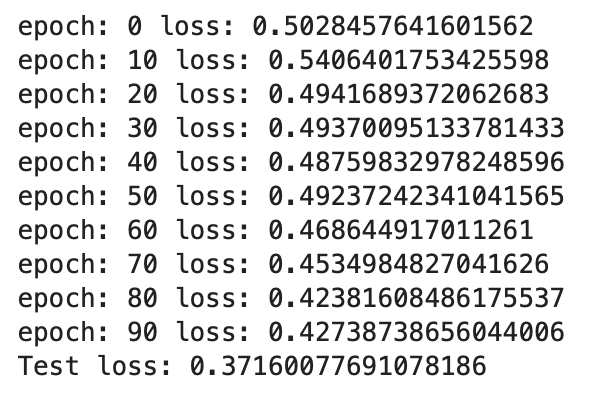

In [ ]:
loss.item()

### Neural Prophet

In [ ]:
from neuralprophet import NeuralProphet, set_log_level

Whenever we use a dataset with NeuralProphet, it must be a pandas dataframe with the following format and properties:

*  Time series column must be named "ds" and contain datetime values.
*  Value column must be named "y" and contain float values.

In [ ]:
train_data

In [ ]:
from neuralprophet import NeuralProphet

train_data = data[['Total']]
train_data = train_data.reset_index().rename(columns={"index": "ds", "Total":"y"})

m = NeuralProphet(yearly_seasonality=True, 
                  weekly_seasonality=True,
                  daily_seasonality=False,)

metrics = m.fit(train_data)

In [ ]:
forecast_np = m.predict(train_data)
forecast_np

In [ ]:
y_pred_np = forecast.iloc[6541:6571]['yhat1']
y_true_np = forecast.iloc[6541:6571]['y']
rmse(y_pred_np, y_true_np)

In [ ]:
m.plot(forecast)

In [ ]:
#df = data.reset_index()
fig = df.plot(x="index", y=["Total", "tavg"], figsize=(10, 6))
plt.xlabel("Date")
plt.legend(['Meals','Temperature'])

In [ ]:
train_data

In [ ]:
# Disable logging messages unless there is an error
set_log_level("ERROR")

# Create a NeuralProphet model
m = NeuralProphet(yearly_seasonality=True, 
                  weekly_seasonality=True,
                  daily_seasonality=False,)

# Fit the model on the dataset (this might take a bit)
metrics = m.fit(train_data)

In [ ]:
# Create a new dataframe reaching 365 into the future for our forecast, n_historic_predictions also shows historic data
df_future = m.make_future_dataframe(train_data, n_historic_predictions=True, periods=14)

# Predict the future
forecast = m.predict(df_future)

# Visualize the forecast
m.plot(forecast)

In [ ]:
metrics

In [ ]:
df

In [ ]:
df = data.reset_index()[['index', 'Total', 'tavg']].rename(columns={'index': 'ds', 'Total':'y', 'tavg':'temperature'})
df

In [ ]:
from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")

# Model and prediction
m = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=10,  # Autogression
)
m.set_plotting_backend("plotly-static")

# Add temperature of last three days as lagged regressor
m.add_lagged_regressor("temperature", n_lags=3)

# Continue training the model and making a prediction
metrics = m.fit(df)
forecast = m.predict(df)

In [ ]:
m.plot(forecast)

In [ ]:
# set plotting to focus on forecasting horizon 1 (the only one for us here)
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

In [ ]:
# visualize model parameters of lagged regression
m.plot_parameters(components=["lagged_regressors"])

In [ ]:
# Create a new dataframe reaching 365 into the future for our forecast, n_historic_predictions also shows historic data
df_future = m.make_future_dataframe(df, n_historic_predictions=True, periods=365)

# Predict the future
forecast = m.predict(df_future)

# Visualize the forecast
m.plot(forecast)

## Time Series Dense Encoder (TiDE)

https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tide_model.html

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime

# Assuming 'df' is your DataFrame with 'ds' for date, 'y' for the target, and 'temperature' as exogenous variable

# Normalize the features
scaler_y = MinMaxScaler(feature_range=(-1, 1))
scaler_temp = MinMaxScaler(feature_range=(-1, 1))
y_normalized = scaler_y.fit_transform(df['y'].values.reshape(-1, 1))
temp_normalized = scaler_temp.fit_transform(df['temperature'].values.reshape(-1, 1))

seq_length = 7  # Updated sequence length

# Update the create_sequences function accordingly
def create_sequences(input_data, target, seq_length):
    xs = []
    ys = []
    for i in range(len(target) - seq_length):
        x = input_data[i:(i+seq_length)]
        y = target[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create the sequences with the updated sequence length
input_data = np.hstack((y_normalized, temp_normalized))
X, y = create_sequences(input_data, y_normalized.flatten(), seq_length)  # Ensure target is flattened

# Convert to PyTorch tensors
X_torch = torch.from_numpy(X).float()
y_torch = torch.from_numpy(y).float()

# The reshape operation should now work correctly given that X has been properly constructed
X_torch = X_torch.reshape(X_torch.shape[0], seq_length, -1)

# Split the data into training and testing sets based on dates
test_start_date = datetime(2023, 11, 30)
test_end_date = datetime(2023, 12, 29)
mask = (df['ds'] >= test_start_date) & (df['ds'] <= test_end_date)

# Test set indices based on mask
test_indices = df.index[mask][seq_length:]  # Exclude first `seq_length` indices

# Split the datasets
X_train = X_torch[~df.index.isin(test_indices)]
y_train = y_torch[~df.index.isin(test_indices)]
X_test = X_torch[df.index.isin(test_indices)]
y_test = y_torch[df.index.isin(test_indices)]

# Define datasets for DataLoader
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# Define DataLoader
batch_size = 64
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime

# Normalize the features
scaler_y = MinMaxScaler(feature_range=(-1, 1))
scaler_temp = MinMaxScaler(feature_range=(-1, 1))
y_normalized = scaler_y.fit_transform(df['y'].values.reshape(-1, 1))
temp_normalized = scaler_temp.fit_transform(df['temperature'].values.reshape(-1, 1))

# Function to create sequences
def create_sequences(input_data, seq_length):
    xs = []
    ys = []
    for i in range(len(input_data)-seq_length):
        x = input_data[i:(i+seq_length)]
        y = input_data[i+seq_length, 0]  # assuming that the target variable 'y' is at 0 position after hstack
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 7  # Updated sequence length

# Create the sequences with the updated sequence length
input_data = np.hstack((y_normalized, temp_normalized))
X, y = create_sequences(input_data, seq_length)

# Convert to PyTorch tensors
X_torch = torch.from_numpy(X).float()
y_torch = torch.from_numpy(y).float().view(-1, 1)  # Reshape y to have the right shape

# Split the data into training and testing sets based on dates
test_start_date = datetime(2023, 11, 30)
test_end_date = datetime(2023, 12, 29)

# Convert date column to datetime for comparison
df['ds'] = pd.to_datetime(df['ds'])

# Create a mask for the test set
mask = (df['ds'] >= test_start_date) & (df['ds'] <= test_end_date)

# Exclude the last seq_length dates for the test set to align the sequences properly
mask_indices = df.index[mask]
mask_indices = mask_indices[mask_indices >= seq_length]

# Prepare the test_indices based on the mask, offset by seq_length to align
test_indices = mask_indices - seq_length

# Split the datasets
X_train = X_torch[~np.isin(range(len(X_torch)), test_indices)]
y_train = y_torch[~np.isin(range(len(y_torch)), test_indices)]
X_test = X_torch[np.isin(range(len(X_torch)), test_indices)]
y_test = y_torch[np.isin(range(len(y_torch)), test_indices)]

# Define datasets for DataLoader
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# Define DataLoader
batch_size = 64
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)


In [ ]:
class LSTMExog(nn.Module):
    def __init__(self, input_size=2, hidden_layer_size=100, output_size=1):
        super(LSTMExog, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

# Instantiate the model
model = LSTMExog(input_size=2, hidden_layer_size=100, output_size=1)

In [ ]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
model.train()
num_epochs = 100
for epoch in range(num_epochs):
    for seq, labels in train_loader:
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'epoch: {epoch}, loss: {single_loss.item()}')

In [ ]:
y_pred

In [ ]:
# Assuming you've already obtained predictions from the model
# and they are stored in a variable called 'predictions'.

# First, get the indices that correspond to the holdout period
holdout_start_idx = df.index[df['ds'] == '2023-11-30'][0] - seq_length
holdout_end_idx = df.index[df['ds'] == '2023-12-29'][0] - seq_length

# Get the true y values for the holdout period and reshape it for inverse transformation
y_test_holdout = y_normalized[holdout_start_idx:holdout_end_idx + 1]
y_test_unscaled = scaler_y.inverse_transform(y_test_holdout).reshape(-1)

# Inverse transform the predicted values (make sure 'predictions' is already a numpy array here)
y_pred_test_unscaled = scaler_y.inverse_transform(y_pred.detach().numpy().reshape(-1, 1)).reshape(-1)

# Now both arrays should be of the same length, corresponding to the holdout period
# Ensure that you only compare the values within the correct indices
y_pred_test_unscaled = y_pred_test_unscaled[:len(y_test_unscaled)]

# Calculate RMSE for the holdout period
rmse = sqrt(mean_squared_error(y_test_unscaled, y_pred_test_unscaled))
print(f'RMSE for the period between November 30, 2023, and December 29, 2023: {rmse}')

In [ ]:
# Assuming you have y_pred_test as a numpy array and not a PyTorch tensor
y_pred_test_unscaled = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1))

# Do the same for y_test if it's a numpy array
y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test_unscaled, y_pred_test_unscaled))
print(f'RMSE for the period between November 30, 2023, and December 29, 2023: {rmse}')


# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test_unscaled, y_pred_test_unscaled))
print(f'RMSE for the period between November 30, 2023, and December 29, 2023: {rmse}')
